In [1]:
# # (-1) Bootstrap
# import sys, subprocess, site, os

# def pipi(args):
#     subprocess.check_call([sys.executable, "-m", "pip"] + args)

# # 0) keep pip compatible with legacy build flow used by some packages
# pipi(["install", "-q", "pip<25.3"])

# # 1) base stack (pinned)
# pipi(["install", "-q", "--upgrade",
#       "numpy==2.2.6",
#       "pandas==2.3.2",
#       "matplotlib==3.10.6",
#       "scipy==1.16.1",
#       "arch==7.2.0",
#       "joblib==1.5.2",
#       "openpyxl==3.1.5",
#       "xlrd==2.0.2"])

# # 2) py-banshee — wheel-first, then PEP517 fallback
# try:
#     pipi(["install", "-q", "--only-binary=:all:", "py-banshee==1.1.2"])
# except subprocess.CalledProcessError:
#     pipi(["install", "-q", "--use-pep517", "py-banshee==1.1.2"])

# # 3) show environment + versions
# import numpy as np, pandas as pd, matplotlib, scipy, joblib
# try:
#     import arch
#     arch_ver = arch.__version__
# except Exception:
#     arch_ver = "n/a"
# try:
#     import py_banshee as _pb
#     banshee_ver = getattr(_pb, "__version__", "installed")
# except Exception:
#     banshee_ver = "not-importable"
# import openpyxl, xlrd

# print(f"Python: {sys.version.split()[0]}")
# print(f"Kernel: {sys.executable}")
# print(f"CONDA_PREFIX: {os.environ.get('CONDA_PREFIX','(none)')}")
# print("site-packages:")
# for p in site.getsitepackages():
#     print("  -", p)
# print("Note: you may need to restart the kernel to use updated packages.")
# print(f"[VERS] numpy={np.__version__} pandas={pd.__version__} matplotlib={matplotlib.__version__} "
#       f"scipy={scipy.__version__} arch={arch_ver} joblib={joblib.__version__} "
#       f"py-banshee={banshee_ver} openpyxl={openpyxl.__version__} xlrd={xlrd.__version__}")



In [2]:
# (0) Session setup (imports, paths, plotting/theme, helpers)
# Purpose:
#   - Import the scientific stack
#   - Define workspace paths and display prefs
#   - Set global plotting controls (PLOT_YEARS, MARK_YEARS, palette)
#   - Provide plotting helpers (apply_plot_years, mark_years)
#   - Provide core data helpers (index alignment, moving means, tests)

# --- Imports
from math import ceil
from pathlib import Path
import io, re, sys, os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.prediction import inference
import py_banshee.rankcorr as _banshee_rc

from scipy.ndimage import convolve1d
from scipy.stats import mannwhitneyu, kruskal, ttest_ind, f_oneway, pearsonr
from IPython.display import display, Markdown

from numpy.lib.stride_tricks import as_strided
from arch.unitroot import ADF as _ARCH_ADF

ROOT = Path(os.environ.get("BCS_ROOT", "")).resolve() if os.environ.get("BCS_ROOT") else None

if ROOT is None:
    cwd = Path.cwd().resolve()
    if cwd.name == "examples" and (cwd.parent / "data").exists():
        ROOT = cwd.parent
    elif (cwd / "data").exists() and (cwd / "examples").exists():
        ROOT = cwd
    else:
        ROOT = cwd.parent

DATA    = ROOT / "data" / "_herons"
RESULTS = ROOT / "results" / "_herons"
RESULTS.mkdir(parents=True, exist_ok=True)

# --- Display preferences (optional but handy for diagnostics)
pd.options.display.float_format = "{:.6g}".format

# --- Display preferences (optional but handy for diagnostics)
pd.options.display.float_format = "{:.6g}".format

# --- Canonical year axes used across the pipeline
YEARS = np.arange(1701, 2024, dtype=int)        # timeline

# --- Labels (used in figure titles/legends)
col_names = ['Narmonka', 'Kichketan', 'Mamadysh', 'Manan-Dur']
loc_names = ['Reference', 'Impacted']

# --- Single source of truth for cohort colors (RGB in [0,1])
#     0: Reference, 1: Impacted
C0, C1 = [0.4660, 0.6740, 0.1880], [0.8500, 0.3250, 0.0980]

# --- Global stats settings for per-year tests
TEST  = "ranksum"   # 'ranksum' | 'kruskal' | 'welch' | 'anova'
ALPHA = 0.05        # two-sided

# Legend handles (match line/marker style across figures)
h_ref = Line2D([], [], ls="--", color=C0, marker="o", mfc="none", mec=C0, ms=6, label=loc_names[0])
h_imp = Line2D([], [], ls="-.", color=C1, marker="^", mfc="none", mec=C1, ms=6, label=loc_names[1])

sig_handle = Line2D([], [], ls="None", marker="^", color="b", mfc=C1, mec="b", ms=7)

# ---------- Core helpers (indexing, transforms, summaries) ----------
def pad_to_years(years_src: np.ndarray, X: np.ndarray, years_axis: np.ndarray) -> np.ndarray:
    """Reindex 2D data (rows=years, cols=variables) onto a target year axis; fill gaps by NaN."""
    df = pd.DataFrame(np.asarray(X, float), index=np.asarray(years_src, int))
    return df.reindex(pd.Index(years_axis, name="year")).to_numpy()

def pad_to_years_matrix(dates_src: np.ndarray, M: np.ndarray,
                        start_year: int = 1700, end_year: int = 2023) -> np.ndarray:
    """Wrapper for monthly climate tables (rows=years, cols=Jan..Dec)."""
    axis = np.arange(start_year, end_year + 1, dtype=int)
    return pad_to_years(dates_src, M, axis)

def monthly_to_sep_aug(M: np.ndarray) -> np.ndarray:
    """
    Realign monthly (Jan..Dec) data to hydrological years (Sep..Aug).
    Implementation: vectorize by columns, drop leading 8 and trailing 4 months,
    then reshape back, so col1=Sep and col12=Aug.
    """
    M = np.asarray(M, float)
    assert M.ndim == 2 and M.shape[1] == 12, "Expected (years × 12) table"
    vec = M.T.flatten(order="F")
    vec = vec[8:-4]  # remove Jan..Aug of first and Sep..Dec of last hydrological year
    assert vec.size % 12 == 0, "Vector length must be divisible by 12 after trimming"
    return np.reshape(vec, (12, -1), order="F").T  # (T × 12), cols=Sep..Aug

def zscore_cols(M: np.ndarray, ddof: int = 1) -> np.ndarray:
    """Column-wise standardization: (X - mean) / std per column (sample std with ddof=1)."""
    M = np.asarray(M, float)
    mu = np.nanmean(M, axis=0)
    sd = np.nanstd(M, axis=0, ddof=ddof)
    sd = np.where(sd == 0, np.nan, sd)
    return (M - mu) / sd

def movmean_rows_center_includenan(M: np.ndarray, k: int = 3) -> np.ndarray:
    """
    Centered moving average over rows with strict NaN propagation.
    A window yields a value only if all k entries are present; edges shrink.
    """
    assert M.ndim == 2
    R, C = M.shape
    ker = np.ones(k, dtype=float)
    X = M.copy()
    nanmask = np.isnan(X)
    X[nanmask] = 0.0
    sum_vals = convolve1d(X, ker, axis=0, mode="constant", cval=0.0, origin=0)
    count    = convolve1d((~nanmask).astype(float), ker, axis=0, mode="constant", cval=0.0, origin=0)
    maxcnt   = np.broadcast_to(convolve1d(np.ones((R, 1)), ker, axis=0, mode="constant", cval=0.0, origin=0), (R, C))
    out = np.full((R, C), np.nan, dtype=float)
    full = (count == maxcnt)
    out[full] = (sum_vals[full] / maxcnt[full])
    return out

def row_nanmean(X: np.ndarray) -> np.ndarray:
    """Row-wise mean with NaN omission; returns NaN for rows with no finite values."""
    X = np.asarray(X, float)
    s = np.nansum(X, axis=1)
    c = np.sum(~np.isnan(X), axis=1)
    out = np.full(X.shape[0], np.nan)
    np.divide(s, c, out=out, where=c > 0)
    return out

def safe_nanmean(A):
    """Scalar NaN-mean: returns np.nan if all-NaN."""
    A = np.asarray(A, float); m = np.isfinite(A)
    return float(A[m].mean()) if m.any() else np.nan

def nanmean_axis_safe(X, axis):
    """Axis-wise mean with NaN omission (shape follows np.nansum)."""
    X = np.asarray(X, float)
    cnt = np.sum(np.isfinite(X), axis=axis)
    sm  = np.nansum(X, axis=axis)
    out = np.full(sm.shape, np.nan)
    np.divide(sm, cnt, out=out, where=cnt > 0)
    return out

# ---------- Per-year two-sample tests ----------
# Listwise year-by-year testing policy:
#   - Compute a p-value only if both cohorts have ≥1 finite observation at that year.
#   - Otherwise return NaN (explicitly avoids imputing structure).
#   - TEST ∈ {'ranksum','kruskal','welch','anova'} controls the test family globally.
def pval_two_group(x0: np.ndarray, x1: np.ndarray, method: str = "ranksum") -> float:
    """
    Two-sample p-value for independent groups (two-sided). NaNs must be removed upstream.
    Methods: 'ranksum' (Mann–Whitney U), 'kruskal', 'welch' (unequal variances), 'anova'.
    """
    n0, n1 = x0.size, x1.size
    if method == "ranksum":
        return mannwhitneyu(x0, x1, alternative="two-sided", method="auto", use_continuity=True).pvalue
    elif method == "kruskal":
        return kruskal(x0, x1, nan_policy="omit").pvalue
    elif method == "welch":
        return ttest_ind(x0, x1, equal_var=False).pvalue if (n0 >= 2 and n1 >= 2) else np.nan
    elif method == "anova":
        return f_oneway(x0, x1).pvalue if (n0 >= 2 and n1 >= 2) else np.nan
    else:
        raise ValueError("method ∈ {'ranksum','kruskal','welch','anova'}")

def pvals_by_year(data: np.ndarray, sel0: np.ndarray, sel1: np.ndarray,
                  dates: np.ndarray, method: str = "ranksum") -> np.ndarray:
    """Per-year p-values: computed only where both cohorts have ≥1 non-NaN observation; else NaN."""
    T = len(dates)
    pvals = np.full(T, np.nan)
    for t in range(T):
        x0 = data[t, sel0]; x1 = data[t, sel1]
        m0 = ~np.isnan(x0);  m1 = ~np.isnan(x1)
        if m0.any() and m1.any():
            pvals[t] = pval_two_group(x0[m0], x1[m1], method=method)
    return pvals

# Pearson correlation with strict listwise deletion:
#   Returns NaN unless there are at least 2 joint finite samples.
#   Centers both vectors and guards against zero variance.
def corr_1d_pairwise(x: np.ndarray, y: np.ndarray) -> float:
    """Listwise Pearson correlation between two 1D arrays; NaN if <2 joint finite samples."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return np.nan
    x0 = x[m] - np.nanmean(x[m])
    y0 = y[m] - np.nanmean(y[m])
    den = np.sqrt(np.dot(x0, x0) * np.dot(y0, y0))
    return float(np.dot(x0, y0) / den) if den > 0 else np.nan


In [3]:
# (*) Diagnostics helper
# --- PURPOSE: light-weight matrix/vector diagnostics
# Notes for readers (methods context):
#   This helper is used throughout to sanity-check shapes, NaN coverage, and quick heads/tails.
#   Keeping diagnostics visible improves reproducibility and auditability of the pipeline.

def diag_print(name: str, X, cols: int = 3) -> None:
    """
    Print concise diagnostics about an array-like object, mirroring the MATLAB diag_print.
    """
    X = np.asarray(X)
    print(f"=== [DIAG] {name} ===")
    print(f"shape = {X.shape}")
    nans = int(np.isnan(X).sum()) if np.issubdtype(X.dtype, np.floating) else 0
    vals = X.size - nans
    pct  = (100 * nans / X.size) if X.size else 0.0
    print(f"NaN = {nans}, non-NaN = {vals} (NaN% = {pct:.2f})")
    if X.ndim == 1:
        h = X[:3]; t = X[-3:] if X.size >= 3 else X
        print("head:", h)
        print("tail:", t)
    elif X.ndim >= 2:
        r = slice(0, min(3, X.shape[0]))
        rr = slice(max(0, X.shape[0]-3), X.shape[0])
        c = slice(0, min(cols, X.shape[1]))
        print("head (first 3 rows, first 3 cols):\n", X[r, c])
        print("tail (last 3 rows, first 3 cols):\n", X[rr, c])


In [4]:
# (1) Load individual TRW and cohort labels → align to canonical year axis
# --- INPUT:  TRW_Chronology.xlsx
# --- OUTPUT: cohort labels (species/colony), location labels, dates (T,), data (T×N), N_trees
# Rationale:
#   Load per-tree TRW series and cohort metadata. Promote the year column to a canonical
#   timeline (YEARS) and reindex with NaN padding. Keep raw per-tree values; no detrending.
#   Convert units (Lintab 0.01 mm → mm).

tbl1 = pd.read_excel(DATA / "TRW_Chronology.xlsx", header=None)

# Metadata rows
colony   = tbl1.iloc[0, 1:].to_numpy(dtype=float)
location = tbl1.iloc[1, 1:].to_numpy(dtype=float)

# Raw time axis + TRW (Lintab-6, 0.01 mm step)
dates_src = tbl1.iloc[3:, 0].to_numpy(dtype=int)
data_src  = tbl1.iloc[3:, 1:].to_numpy(dtype=float)

# Reindex to canonical axis and convert to millimeters (e.g., 800 -> 8.00 mm)
data  = pad_to_years(dates_src, data_src, YEARS) / 100.0
dates = YEARS.copy()
N_trees = data.shape[1]

# [DIAG]
# diag_print("TRW data (mm)", data)
# print(f"[DIAG] years: {dates[0]}..{dates[-1]} (T={len(dates)}), N_trees={N_trees}")
# diag_print("colony(row1)", colony[None, :])
# diag_print("location(row2)", location[None, :])


In [5]:
# (2) PDSI ingestion (monthly) → hydrological years (Sep–Aug); pad & realign
# --- INPUT:  monthly PDSI file (Jan..Dec)
# --- OUTPUT: PDSI (T×12, Sep..Aug)
# Rationale:
#   Read monthly PDSI, pad its year index to the TRW domain, and realign to hydrological
#   years (Sep..Aug) to capture late-season carry-over. Preserve the monthly structure
#   for multi-year lag stacking downstream.

tbl3 = pd.read_csv(
    DATA / "iscpdsi_50.00E_55.50N_firstyear-lastyear_n.dat.txt",
    sep=r"\s+", header=None, engine="python"
)
dates3_raw = tbl3.iloc[:, 0].to_numpy(int)
PDSI_mon   = tbl3.iloc[:, 1:13].to_numpy(float)

PDSI_pad = pad_to_years_matrix(dates3_raw, PDSI_mon, start_year=1700, end_year=2023)
PDSI     = monthly_to_sep_aug(PDSI_pad)            # (T × 12), cols = Sep..Aug

# [DIAG]
# diag_print("PDSI monthly Sep–Aug", PDSI)
# print(f"[DIAG] PDSI years after shift: T={PDSI.shape[0]}")


In [6]:
# (3) Temperature ingestion → hydrological years (Sep–Aug); pad & realign
# --- INPUT:  legacy .xls with Year + 12 months
# --- OUTPUT: Temp (T×12, Sep–Aug)
# Rationale:
#   Parse the legacy sheet (no headers), detect/use the Year column and the 12 monthly columns,
#   pad to the TRW domain, then realign to Sep–Aug.

tbl4      = pd.read_excel(DATA / "Kazan_temp_2022neww.xls", sheet_name=0, header=None, engine="xlrd")
dates4_raw = tbl4.iloc[1:, 0].to_numpy(int)
Temp_mon   = tbl4.iloc[1:, 1:13].to_numpy(float)

Temp_pad = pad_to_years_matrix(dates4_raw, Temp_mon, start_year=1700, end_year=2023)
Temp     = monthly_to_sep_aug(Temp_pad)

# [DIAG]
# diag_print("Temp monthly Sep–Aug", Temp)
# print(f"[DIAG] Temp years after shift: T={Temp.shape[0]}")


In [7]:
# (4) Standardization of climate variability indicators
# --- INPUT: Temp, PDSI
# --- OUTPUT: Temp, PDSI
# Rationale:
#   Per-month normalization makes seasonal features comparable across years:
#   for each month, subtract the long-term mean and divide by sample std (ddof=1).

Temp = zscore_cols(Temp, ddof=1)
PDSI = zscore_cols(PDSI, ddof=1)

# [DIAG]
# diag_print("Temp stdzd", Temp)
# diag_print("PDSI stdzd", PDSI)


In [8]:
# (5) Multi-year monthly lag stacks (5×12) for climate predictors
# --- INPUT:  PDSI (T×12), Temp (T×12)
# --- OUTPUT: data_multi_year_PDSI (T×60), data_multi_year_Temp (T×60)
# Rationale:
#   For each climate table, concatenate the current hydrological year and 4 previous years
#   (lags 0..4) to form a 60-column predictor block per time step (top-padded with NaNs).

def multi_year_monthly_blocks(M: np.ndarray, max_lag: int = 4) -> np.ndarray:
    """5-year lag stack: (T×60) = [lag4 | lag3 | lag2 | lag1 | lag0], each block 12 months."""
    T = M.shape[0]
    blocks = []
    for lag in (4, 3, 2, 1, 0):
        if lag > 0:
            blk = np.vstack([np.full((lag, 12), np.nan), M[:T-lag, :]])
        else:
            blk = M.copy()
        blocks.append(blk)
    return np.hstack(blocks)

data_multi_year_PDSI = multi_year_monthly_blocks(PDSI, max_lag=4)
data_multi_year_Temp = multi_year_monthly_blocks(Temp,  max_lag=4)

# [DIAG]
# diag_print("data_multi_year_PDSI (T x 60)", data_multi_year_PDSI)
# diag_print("data_multi_year_Temp (T x 60)", data_multi_year_Temp)


In [9]:
# (6) Seasonal smoothing → 10+10 features; standardize and pack predictors
# --- INPUT:  data_multi_year_* (T×60), data (T×N), N_trees
# --- OUTPUT: data_seasonal_* (T×20), stats0 (T×20), data1 (T×21×N)
# Rationale:
#   Apply centered 3-month smoothing with strict NaN propagation to the 60-cols stacks,
#   keep the central month of each triplet → 20 seasonal features. Z-score columns (ddof=1)
#   after smoothing, then horizontally stack 10 PDSI + 10 Temp into stats0. Broadcast stats0
#   across trees and append the TRW channel to obtain data1.

def _seasonal_from_multiyear_monthly_mat(mm60: np.ndarray) -> np.ndarray:
    tmp   = mm60.T                                      # (60, T)
    sm    = movmean_rows_center_includenan(tmp, k=3)    # (60, T)
    mm_sm = sm.T                                        # (T, 60)
    return mm_sm[:, 1::3]                               # (T, 20) — central months

data_seasonal_PDSI = _seasonal_from_multiyear_monthly_mat(data_multi_year_PDSI)
data_seasonal_Temp = _seasonal_from_multiyear_monthly_mat(data_multi_year_Temp)

# Preserve original order: Temp (10) then PDSI (10)
stats0 = np.hstack([data_seasonal_Temp[:, 10:20], data_seasonal_PDSI[:, 10:20]])  # (T, 20)

#   We build climate predictors once and use exactly the same set downstream (IC and NPBN).
#   Pipeline:
#     1) Take 5 hydrological years (Sep–Aug) of monthly data: 12×5 = 60 months, arranged as
#        [lag4 | lag3 | lag2 | lag1 | lag0], top-padded with NaNs to keep alignment.
#     2) Apply centered 3-month smoothing with strict NaN propagation over the 60-month stack.
#     3) Keep each triplet’s central month → 20 “seasonal” features per climate table.
#     4) Standardize columns (ddof=1).
#   Finally, we keep the **last 10** seasonal features (columns 11..20) from each table. These
#   correspond to the most recent ~2.5 years (4 features for lag0, 4 for lag1, 2 for lag2).
#   Concatenating PDSI(11..20) and Temp(11..20) yields `stats0` (T×20).
#   Both the IC branch (whitening/décorrelation) and the NPBN branch (conditional inference)
#   consume the same `stats0`. Differences come solely from the conditioning method, not from
#   the predictor definition.

# Pack into (T × 21 × N_trees): 20 climate + 1 TRW channel
stats0_3d = np.repeat(stats0[:, :, None], N_trees, axis=2)
data1     = np.concatenate([stats0_3d, data[:, None, :]], axis=1)

# [DIAG]
# diag_print("data_seasonal_PDSI (T x 20)", data_seasonal_PDSI)
# diag_print("data_seasonal_Temp (T x 20)", data_seasonal_Temp)
# diag_print("stats0 (T x 20)", stats0)
# print(f"[DIAG] data1 size = {data1.shape[0]}x{data1.shape[1]}x{data1.shape[2]}")


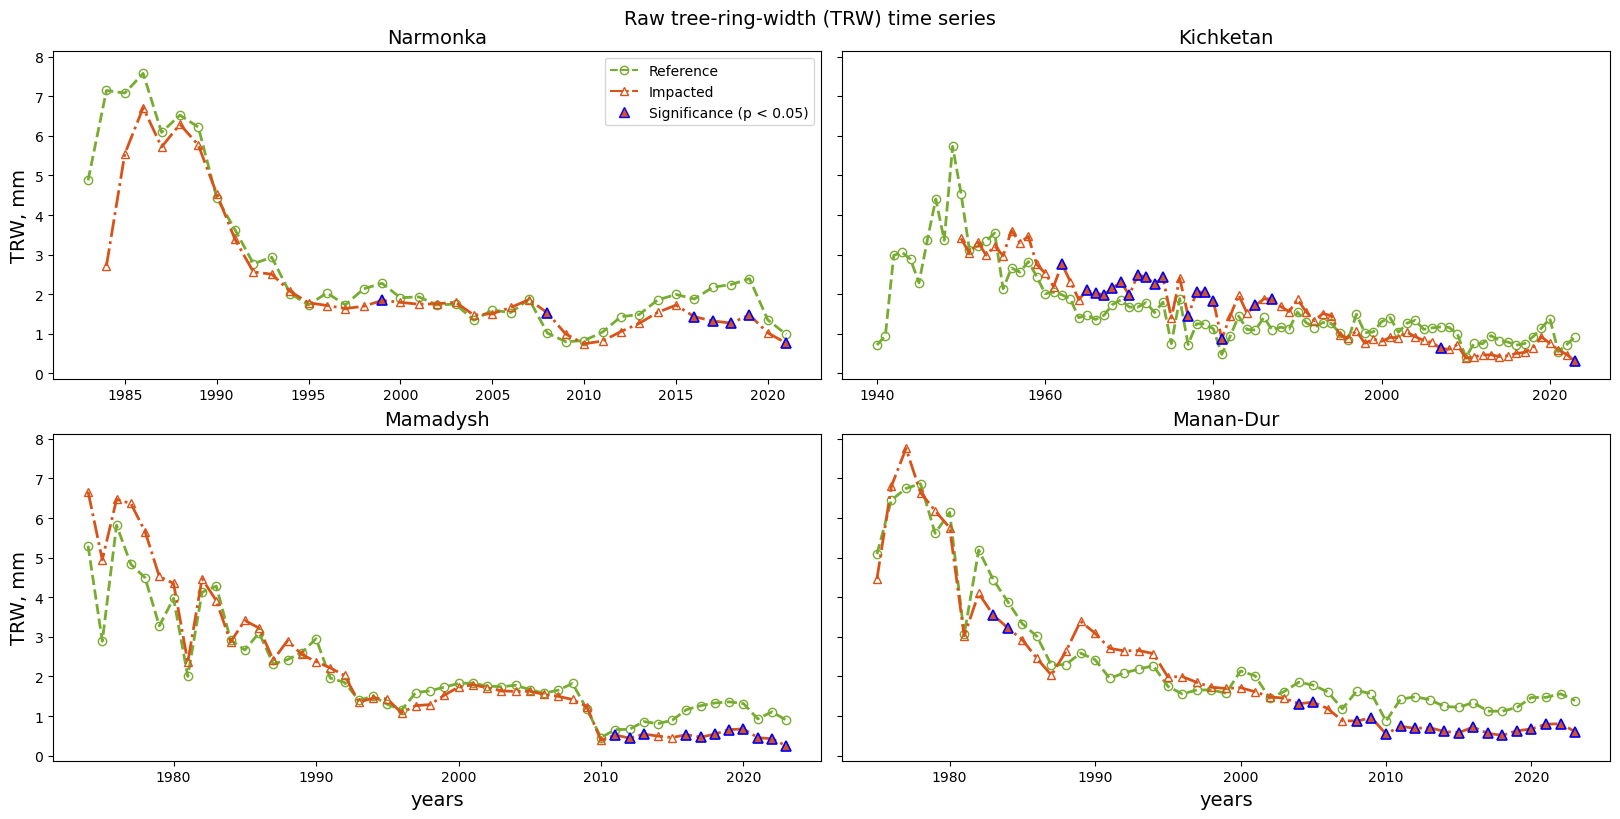

In [30]:
# (7) Raw TRW time series — cohort means with per-year significance overlays
# --- INPUT:  data (T×N), dates (T,), cohort labels, location labels
# --- OUTPUT: Figure_1.pdf, TRW_1.csv
# Rationale:
#   Compute cohort means (row-wise NaN-means) and test per-year differences vs the reference
#   cohort using the selected two-sample test (TEST). Overlay significant years and share axes
#   across panels for comparability.

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, col_id in zip(axes, col_ids):
    sel_ref = (colony == col_id) & (location == 0)  # Reference
    sel_imp = (colony == col_id) & (location == 1)  # Impacted

    y_ref = row_nanmean(data[:, sel_ref]) if sel_ref.any() else np.full(T, np.nan)
    y_imp = row_nanmean(data[:, sel_imp]) if sel_imp.any() else np.full(T, np.nan)

    # Per-year tests (Reference vs Impacted)
    P = pvals_by_year(data, sel_ref, sel_imp, dates, method=TEST)
    sig = np.isfinite(P) & (P < ALPHA)

    # Mean curves (o/^; unfilled markers on curves)
    ax.plot(dates, y_ref, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y_imp, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    # Significance overlay (Impacteds where p<ALPHA)
    y1_sig = y_imp.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

    # Titles + edge-only axis labels (left column → ylabel; bottom row → xlabel)
    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('TRW, mm', fontsize=14)
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)

    # [DIAG] (inside the loop)
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG] Colony {col_id}: n_ref={sel_ref.sum()}, n_imp={sel_imp.sum()}, "
    #       f"significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle('Raw tree-ring-width (TRW) time series', fontsize=14)

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")

fig.savefig(RESULTS / "Figure_1.pdf", format="pdf")
pd.DataFrame(data).to_csv(RESULTS / "TRW_1.csv", index=False, header=False)
plt.show()


_HAVE_JOBLIB = True
_JOBS = 3
S-grid = [11..50], Sd = 35


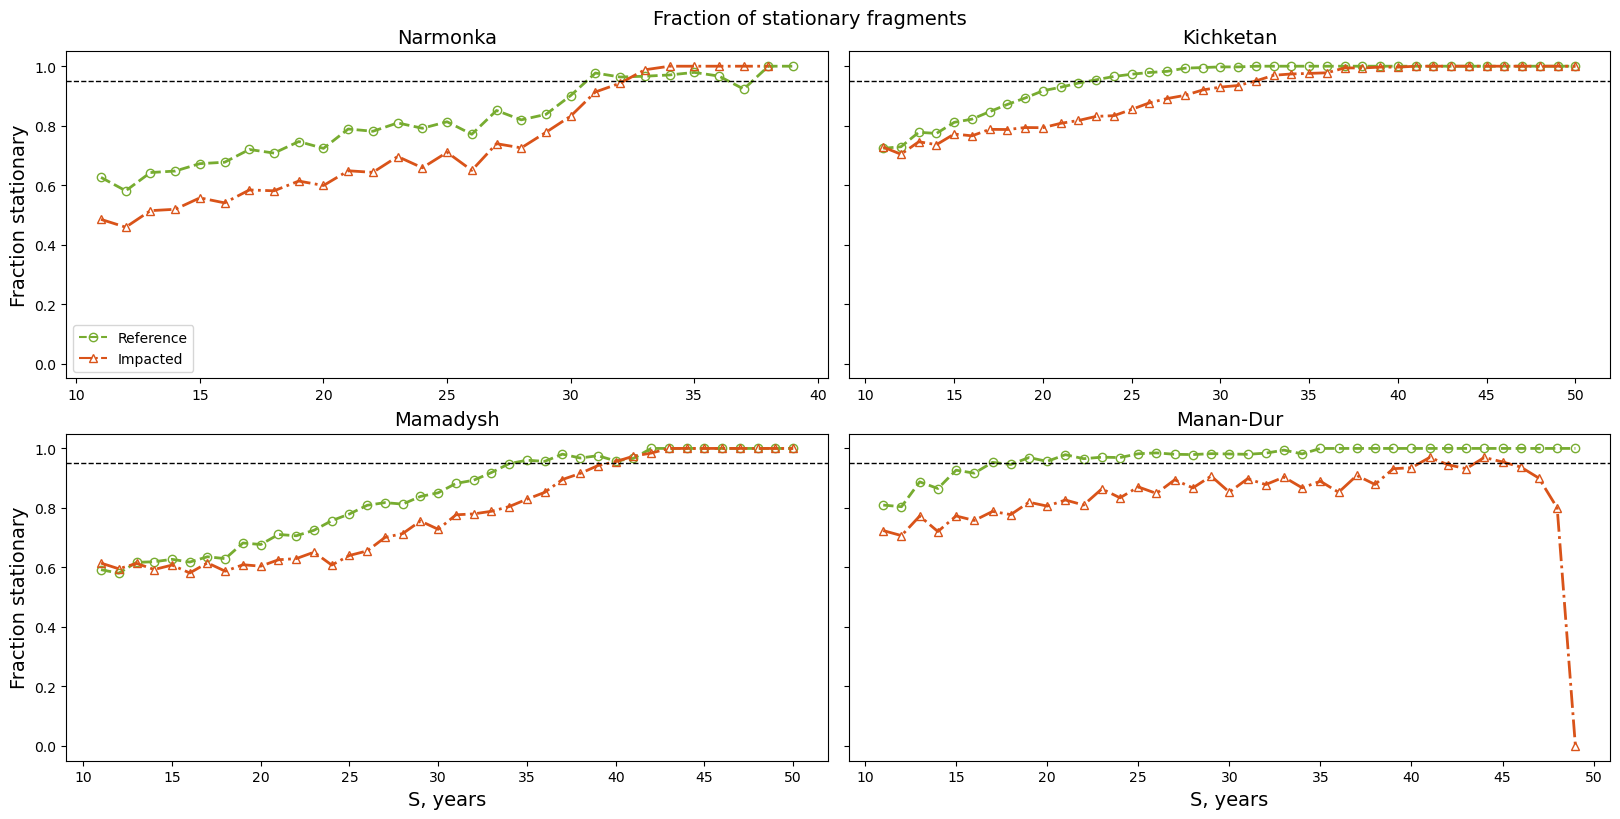

In [11]:
# (8) Decomposition into long-term trend & stationary fluctuations + ADF stationarity grid
# --- INPUT:  data (T×N), dates (T,), cohort labels
# --- OUTPUT: data_trend (T×N), data_fluct (T×N), ADF_3d (T×N×|S|), Sd, Figure_2.pdf
# Rationale:
#   For S∈{11..50} compute k-year centered moving-mean trends and residual fluctuations.
#   Partition residuals into non-overlapping S-blocks across all phase offsets and assess
#   stationarity with the Augmented Dickey–Fuller test. Pick Sd as the smallest S with mean
#   stationary coverage > THRESHOLD (or argmax otherwise). Visualize coverage by cohort.

# ---------- Parameters ----------
S = np.arange(11, 51)   # candidate window sizes
ADF_ALPHA    = 0.05
ADF_MODEL    = 'AR'     # 'AR' (no constant), 'ARD' (constant), 'TS' (const+trend)
ADF_LAGS     = 0
NAN_POLICY   = 'strict' # 'strict': skip any block containing NaNs
THRESHOLD    = 0.95
VAR_EPS      = 1e-12
ADF_DECISION = 'crit'   # 'crit'|'pvalue'|'auto'

try:
    from joblib import Parallel, delayed
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

print(f"_HAVE_JOBLIB = {_HAVE_JOBLIB}")
_TREND_MAP = {'AR': 'n', 'ARD': 'c', 'TS': 'ct'}

# ADF wrapper (arch.unitroot.ADF) with NaN/variance guards:
#   - 'strict' policy skips any block containing NaNs; 'omit' drops NaNs column-wise.
#   - If variance ≤ VAR_EPS, treat as stationary (degenerate) to avoid numerical issues.
#   - Decision by 'crit' uses the 5% critical value; 'pvalue' uses reported p-value.
def adf_arch(y: np.ndarray, model='AR', lags=0, alpha=0.05,
             nan_policy='strict', decision='auto'):
    """ADF wrapper using arch.unitroot.ADF; returns (h, p) with NaN-safe guards."""
    y = np.asarray(y, float)
    if nan_policy == 'strict' and np.isnan(y).any(): return np.nan, np.nan
    if nan_policy == 'omit': y = y[np.isfinite(y)]
    if y.size < 3: return np.nan, np.nan
    if np.nanvar(y) <= VAR_EPS: return 1.0, 0.0
    try:
        res  = _ARCH_ADF(y, lags=int(lags), trend=_TREND_MAP.get(model.upper(), 'n'))
        stat = float(res.stat)
        p    = float(res.pvalue) if np.isfinite(res.pvalue) else np.nan
        use_crit = (decision == 'crit') or (decision == 'auto' and abs(alpha-0.05) < 1e-12)
        if use_crit and ('5%' in res.critical_values):
            h = float(stat <= res.critical_values['5%'])
        else:
            h = float(p < alpha) if np.isfinite(p) else np.nan
        return h, p
    except Exception:
        return np.nan, np.nan

def _strided_block_view(X: np.ndarray, k: int):
    """All phase-aligned blocks of length k as one 3D view: (B × k × N) using strides."""
    T, N = X.shape
    views = []
    for s in range(k):
        Xs = X[s:, :]
        B  = Xs.shape[0] // k
        if B == 0: continue
        Xtrim   = Xs[:B*k, :]
        shape   = (B, k, N)
        strides = (k*Xtrim.strides[0], Xtrim.strides[0], Xtrim.strides[1])
        views.append(as_strided(Xtrim, shape=shape, strides=strides, writeable=False))
    return np.concatenate(views, axis=0) if views else np.empty((0, k, X.shape[1]), float)

# Core computation
data = np.asarray(data, float); T, N = data.shape; L = len(S)
data_trend_3d = np.full((T, N, L), np.nan)
data_fluct_3d = np.full((T, N, L), np.nan)
ADF_3d        = np.full((T, N, L), np.nan)

_JOBS = max(1, (os.cpu_count() or 2) - 1)
print(f"_JOBS = {_JOBS}")

for li, k in enumerate(S):
    # centered moving mean via pandas (NaN-aware, edge-shrinking)
    trend = pd.DataFrame(data).rolling(window=int(k), center=True, min_periods=1).mean().to_numpy()
    fluct = data - trend
    data_trend_3d[:, :, li] = trend
    data_fluct_3d[:, :, li] = fluct

    # all k-length blocks across all phase offsets
    blocks = _strided_block_view(fluct, k)   # (B × k × N)
    B = blocks.shape[0]
    Bcap = min(B, T)                          # parity with downstream expectations
    if Bcap == 0: continue

    # parallel ADF across blocks
    if _HAVE_JOBLIB and _JOBS > 1:
        rows = Parallel(n_jobs=_JOBS, backend='loky', batch_size='auto')(
            delayed(lambda seg: np.array([
                adf_arch(seg[:, j], model=ADF_MODEL, lags=ADF_LAGS,
                         alpha=ADF_ALPHA, nan_policy=NAN_POLICY, decision=ADF_DECISION)[0]
                if ((NAN_POLICY=='strict' and not np.isnan(seg[:, j]).any()) or
                    (NAN_POLICY!='strict' and np.isfinite(seg[:, j]).sum()>=3))
                else np.nan for j in range(seg.shape[1])
            ]))(blocks[b, :, :]) for b in range(Bcap)
        )
        res = np.vstack(rows)
    else:
        res = np.vstack([
            np.array([
                adf_arch(blocks[b, :, j], model=ADF_MODEL, lags=ADF_LAGS,
                         alpha=ADF_ALPHA, nan_policy=NAN_POLICY, decision=ADF_DECISION)[0]
                if ((NAN_POLICY=='strict' and not np.isnan(blocks[b, :, j]).any()) or
                    (NAN_POLICY!='strict' and np.isfinite(blocks[b, :, j]).sum()>=3))
                else np.nan for j in range(N)
            ]) for b in range(Bcap)
        ])
    ADF_3d[:Bcap, :, li] = res

# choose Sd
mean_over = np.array([safe_nanmean(ADF_3d[:, :, li]) for li in range(L)])
gt = np.where(mean_over > THRESHOLD)[0]
Sd_idx = int(gt[0]) if gt.size else int(np.nanargmax(mean_over))
Sd = int(S[Sd_idx])
print(f"S-grid = [{S[0]}..{S[-1]}], Sd = {Sd}")

# final outputs
data_trend = data_trend_3d[:, :, Sd_idx]
data_fluct = data_fluct_3d[:, :, Sd_idx]

# Visualization: fraction of stationary fragments by colony (Reference vs Impacted)
col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, col_id in zip(axes, col_ids):
    sel_ref = (colony == col_id) & (location == 0)
    sel_imp = (colony == col_id) & (location == 1)

    y_ref = [safe_nanmean(ADF_3d[:, sel_ref, li]) if sel_ref.any() else np.nan for li in range(L)]
    y_imp = [safe_nanmean(ADF_3d[:, sel_imp, li]) if sel_imp.any() else np.nan for li in range(L)]

    ax.plot(S, y_ref, linestyle='--', linewidth=2, marker='o', markersize=6,
            color=C0, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(S, y_imp, linestyle='-.', linewidth=2, marker='^', markersize=6,
            color=C1, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    ax.axhline(THRESHOLD, color='k', linestyle='--', linewidth=1)
    ttl = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(ttl, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('Fraction stationary', fontsize=14)
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel("S, years", fontsize=14)

axes[0].legend([h_ref, h_imp], [loc_names[0], loc_names[1]], loc='best')
fig.suptitle('Fraction of stationary fragments', fontsize=14)
plt.savefig(RESULTS / "Figure_2.pdf", format="pdf")
plt.show()


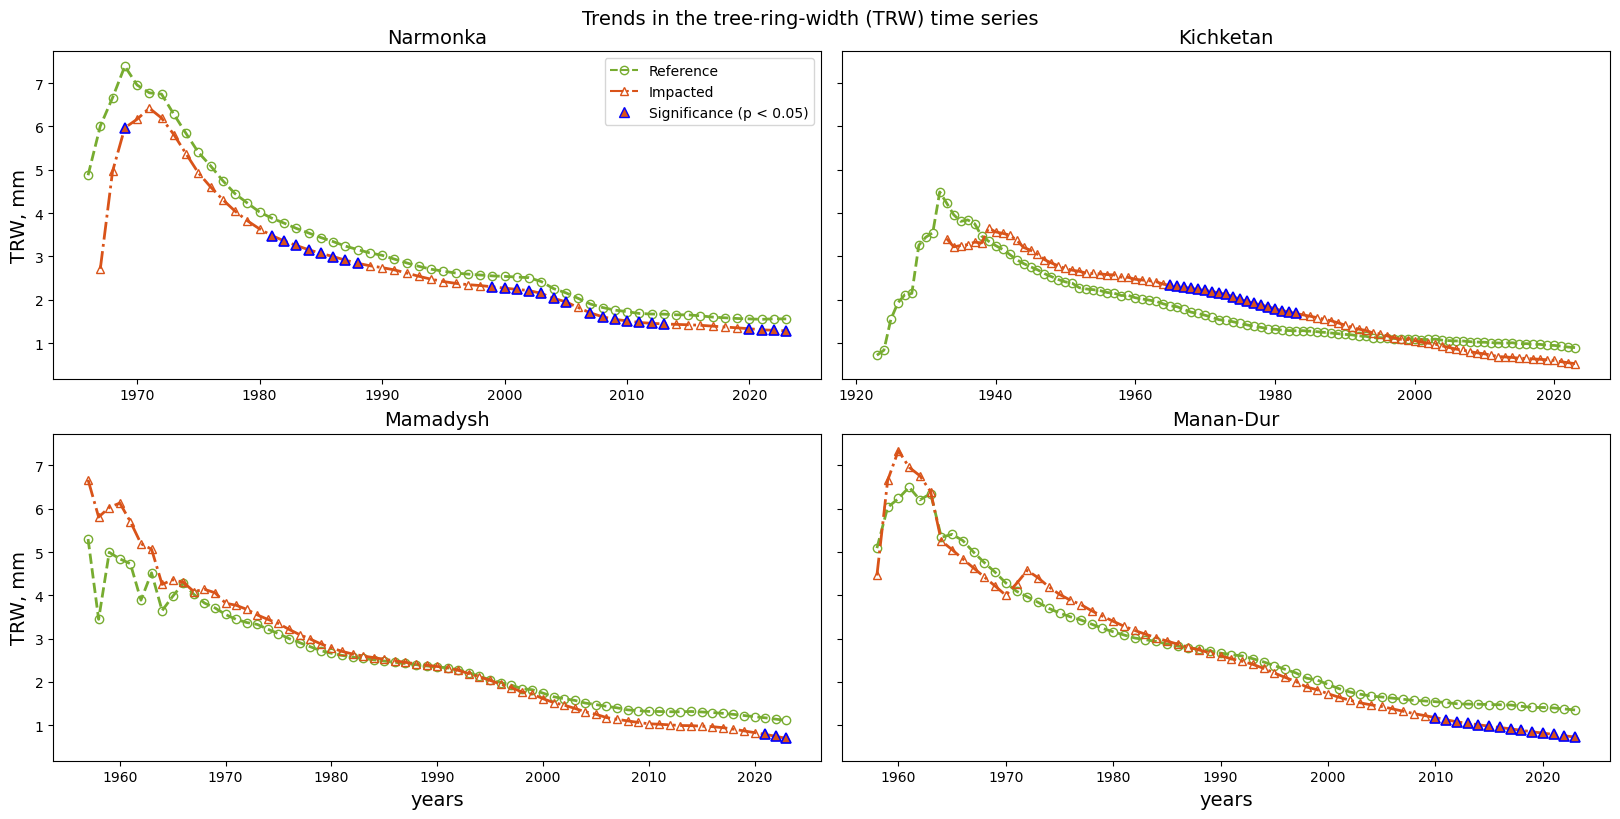

In [12]:
# (9) TRW trend comparison by cohort (reference vs impacted)
# --- INPUT:  data_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_3.pdf, TRW_3.csv
# Rationale:
#   Plot cohort-mean long-term trends and mark per-year differences (p<ALPHA).

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)  

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)
    sel1 = (colony == col_id) & (location == 1)

    y0 = row_nanmean(data_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)

    # cohort mean curves
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])  
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])  

    # per-year tests
    Pval = pvals_by_year(data_trend, sel0, sel1, dates, method=TEST)
    sig = np.isfinite(Pval) & (Pval < ALPHA) 
    
    # highlight significant years for Impacted
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2) 

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('TRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14) 

    # [DIAG] 
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][TREND] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})") 

fig.suptitle('Trends in the tree-ring-width (TRW) time series', fontsize=14)

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')

fig.savefig(RESULTS / "Figure_3.pdf", format="pdf")
pd.DataFrame(data_trend).to_csv(RESULTS / "TRW_3.csv", index=False, header=False)
plt.show()


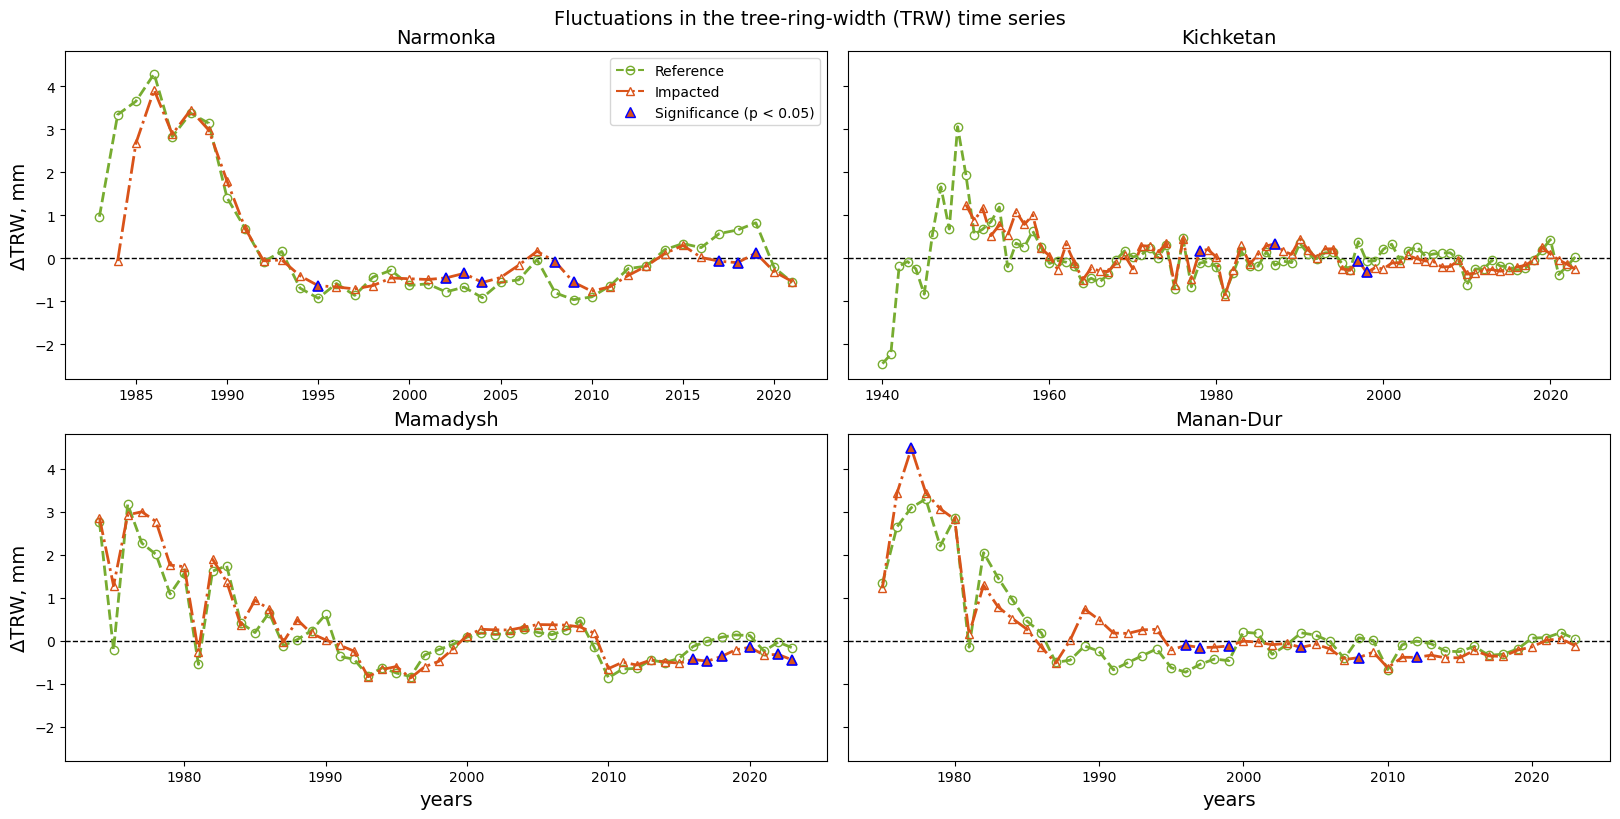

In [13]:
# (10) TRW fluctuation comparison by cohort (reference vs impacted)
# --- INPUT:  data_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_4.pdf, TRW_4.csv
# Rationale:
#   Plot cohort-mean stationary fluctuations (around the trend) with a zero baseline and
#   per-year significance overlays vs the reference cohort.

T = len(dates)
col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)  
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)  

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)
    sel1 = (colony == col_id) & (location == 1)

    y0 = row_nanmean(data_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])  
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])  

    Pval = pvals_by_year(data_fluct, sel0, sel1, dates, method=TEST)
    sig = np.isfinite(Pval) & (Pval < ALPHA)  

    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)  

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)  
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)   

    # [DIAG] 
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][FLUCT] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle('Fluctuations in the tree-ring-width (TRW) time series', fontsize=14)

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')
  
fig.savefig(RESULTS / "Figure_4.pdf", format="pdf") 
pd.DataFrame(data_fluct).to_csv(RESULTS / "TRW_4.csv", index=False, header=False)
plt.show()


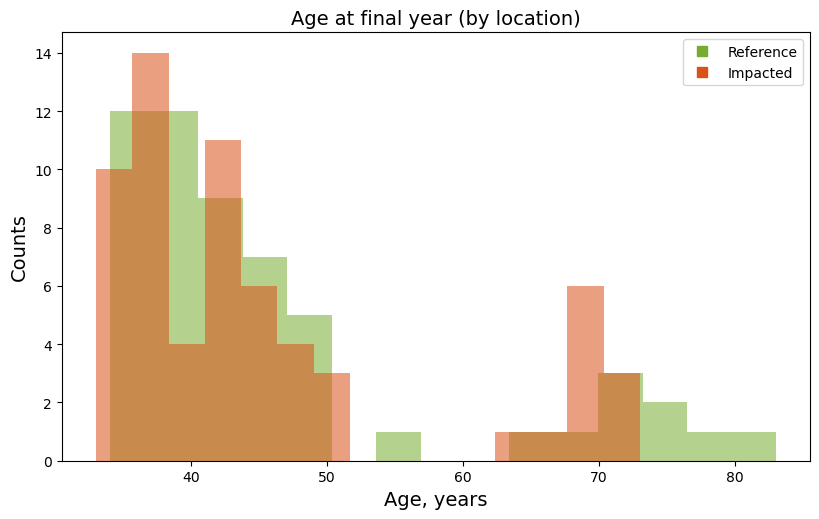

In [14]:
# (11) Derive tree birth years and age matrix; age histogram by location
# --- INPUT:  data (T×N), dates (T,), location (N,)
# --- OUTPUT: birth (N,), age (T×N)
# Rationale:
#   Birth year = first finite TRW observation per tree. Age(t,j)=year_t−birth_j with negatives masked.
#   Inspect end-year age distributions by location to reveal cohort age structures.

T, N = data.shape

birth = np.full(N, np.nan)
finite_mask = np.isfinite(data)
for j in range(N):
    idx = np.where(finite_mask[:, j])[0]
    if idx.size:
        birth[j] = dates[idx[0]]

age = dates[:, None] - birth[None, :]
age[age < 0] = np.nan

# Histogram of ages at the final year by location
fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.0)

bins = 15
loc_vals = np.sort(np.unique(location[np.isfinite(location)])).astype(int)  # expect {0,1}
for lv in loc_vals:
    sel  = (location == lv)
    vals = age[-1, sel]
    vals = vals[np.isfinite(vals)]
    if vals.size:
        ax.hist(
            vals,
            bins=bins,
            alpha=0.55,
            label=loc_names[lv],                      
            color=(C0 if lv == 0 else C1),
            edgecolor='none'
        )

ax.set_title("Age at final year (by location)", fontsize=14)
ax.set_xlabel("Age, years", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.legend([Line2D([], [], ls="None", marker="s", color=C0, mfc=C0, mec=C0, ms=7), Line2D([], [], ls="None", marker="s", color=C1, mfc=C1, mec=C1, ms=7)],
          [loc_names[0], loc_names[1]],loc='best')
plt.show()


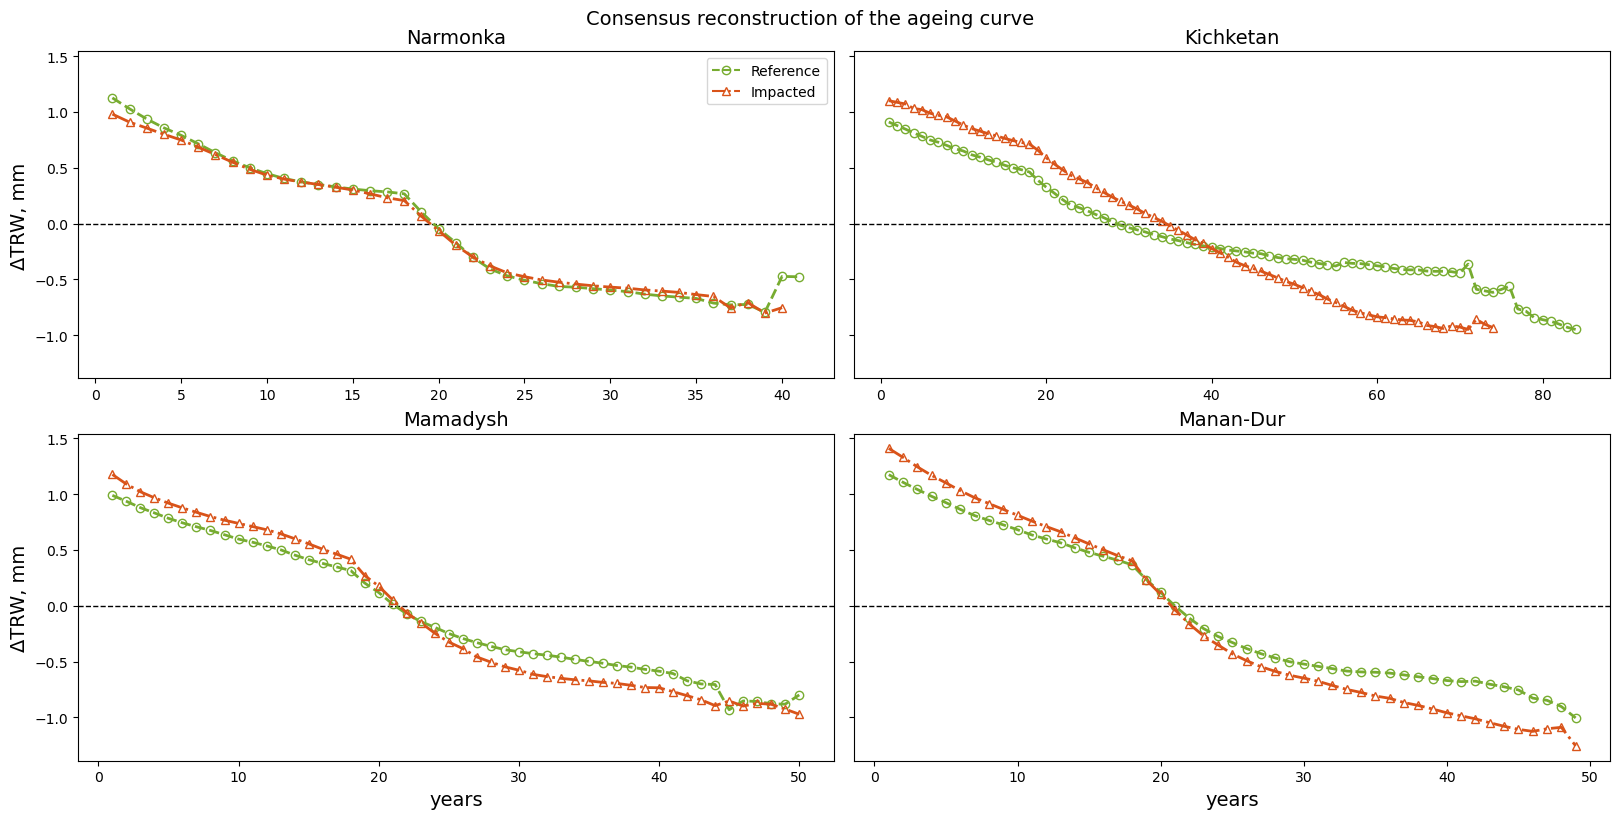

In [15]:
# (12) Consensus age–growth curve (cohort × location) and broadcasting
# --- INPUT:  data_trend (T×N), dates (T,), birth (N,), cohort & location labels
# --- OUTPUT: A (T×N), A2 (T×N), A_cohort (T×⋯×loc), Figure_5.pdf, TRW_5.csv
# Rationale:
#   Align trends by biological age (age-synchronous stacking) within each cohort×location,
#   compute consensus ageing profiles, zero-center them by cohort mean, and broadcast back
#   to trees (A2). Plot consensus curves to validate shape realism.

A  = np.full((T, N), np.nan)
A2 = np.full((T, N), np.nan)   # colony×location consensus profile broadcast to each tree

dates_i = np.rint(dates).astype(int)
birth_i = np.rint(birth).astype(int)

# place each tree’s trend starting at its birth year
for j in range(N):
    if not np.isfinite(birth[j]): continue
    start = birth_i[j] - dates_i[0]
    if 0 <= start < T:
        seg = data_trend[start:, j]
        A[:seg.shape[0], j] = seg

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)
A_col = np.full((T, len(col_ids), 2), np.nan)  # T × nCol × {Ref,Imp}

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

age_x = np.arange(1, T+1)

for ax, col_id in zip(axes, col_ids):
    ci = list(col_ids).index(col_id)

    sel_ref = (colony == col_id) & (location == 0)
    sel_imp = (colony == col_id) & (location == 1)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    
    if sel_ref.any():
        prof_rows = nanmean_axis_safe(A[:, sel_ref], axis=1)
        mu_all    = safe_nanmean(A[:, sel_ref])
        prof0     = prof_rows - mu_all
        A_col[:, ci, 0] = prof0
        A2[:, sel_ref]  = prof0[:, None]
        ax.plot(age_x, prof0, linestyle='--', linewidth=2, marker='o', markersize=6,
                color=C0, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])

    if sel_imp.any():
        prof_rows = nanmean_axis_safe(A[:, sel_imp], axis=1)
        mu_all    = safe_nanmean(A[:, sel_imp])
        prof1     = prof_rows - mu_all
        A_col[:, ci, 1] = prof1
        A2[:, sel_imp]  = prof1[:, None]
        ax.plot(age_x, prof1, linestyle='-.', linewidth=2, marker='^', markersize=6,
                color=C1, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (ci % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (ci // 2) == 1:
        ax.set_xlabel('years', fontsize=14)  # age index plotted along X; we still label "years" for consistency

axes[0].legend([h_ref, h_imp], [loc_names[0], loc_names[1]], loc='best')
plt.suptitle("Consensus reconstruction of the ageing curve", fontsize=14)

plt.savefig(RESULTS / "Figure_5.pdf", format="pdf")
pd.DataFrame(A).to_csv(RESULTS / "TRW_5.csv", index=False, header=False)
plt.show()


In [16]:
# (13) Age-baseline removal (age-rectified trend)
# --- INPUT:  data_trend (T×N), A2 (T×N), dates (T,), birth (N,)
# --- OUTPUT: data_trend_noage (T×N)
# Rationale:
#   Subtract the broadcast consensus age profile per tree, aligned to its birth, to remove
#   age-related baseline while preserving calendar alignment.

data_trend_noage = np.full_like(data, np.nan)

dates_i = np.rint(dates).astype(int)
birth_i = np.rint(birth).astype(int)

for j in range(N):
    if not np.isfinite(birth[j]):
        continue
    start = birth_i[j] - dates_i[0]
    if 0 <= start < T:
        L = data_trend[start:, j].shape[0]
        data_trend_noage[start:, j] = data_trend[start:, j] - A2[:L, j]

# [DIAG]
# diag_print("data_trend_noage (T x N)", data_trend_noage)

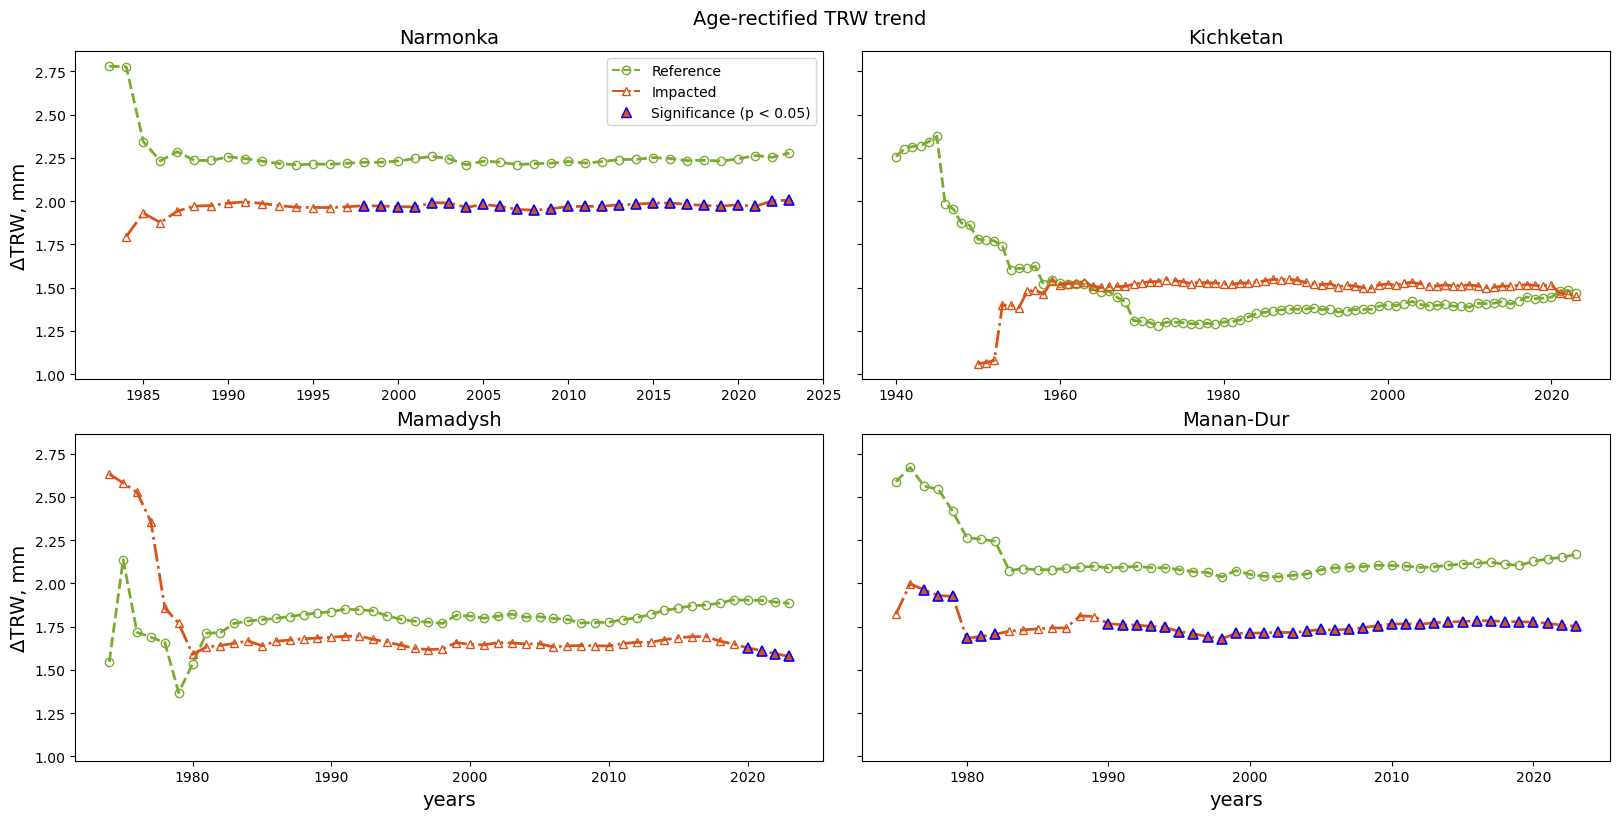

In [17]:
# (14) Age-rectified TRW trend — cohort comparison with per-year tests
# --- INPUT:  data_trend_noage (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_6.pdf, TRW_6.csv
# Rationale:
#   After removing age effects, test whether cohort means still differ at each year (p<ALPHA).

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True) 
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02) 

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)   # Reference
    sel1 = (colony == col_id) & (location == 1)   # Impacted

    y0 = row_nanmean(data_trend_noage[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data_trend_noage[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    # per-year tests 
    Pval = pvals_by_year(data_trend_noage, sel0, sel1, dates, method=TEST)
    sig  = np.isfinite(Pval) & (Pval < ALPHA) 

    # highlight Impacted where significant
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)   

    # [DIAG]
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][TREND_NOAGE] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")
    
fig.suptitle('Age-rectified TRW trend', fontsize=14)  

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')
fig.savefig(RESULTS / "Figure_6.pdf", format="pdf")  
pd.DataFrame(data_trend_noage).to_csv(RESULTS / "TRW_6.csv", index=False, header=False)
plt.show()


In [18]:
# (14) NPBN helpers — py_banshee cache safety shim + single-line Jupyter progress
# --- INPUT:  —
# --- OUTPUT:  inference_with_live_line(...); patched rankcorr helpers
# Rationale:
#   Patch rank-correlation cache helpers to be robust to large parent sets (Python big ints).
#   Provide a live single-line progress wrapper for NPBN inference. Scientific API unchanged.

if not getattr(_banshee_rc, "_shim_ok", False):
    def _calc_val_safe(cond, m):
        """Stable polynomial hash for a parent set 'cond' given base 'm' (pure Python big ints)."""
        if not cond:
            return 0
        sc = sorted(int(c) for c in cond)
        v = 0
        p = 1
        m = int(m)
        for c in sc:              # v += (c+1) * m**i
            v += (c + 1) * p
            p *= m
        return int(v)

    def _add_corr_safe(Lc, val, r):
        """
        Normalize a cache cell 'Lc' to a list of [key, corr] and upsert (val -> r).
        Prevents 'int is not subscriptable' and dtype issues in rankcorr.PartCorr().
        """
        recs = []
        if isinstance(Lc, (int, float, np.integer, np.floating)) or Lc is None:
            recs = []
        else:
            try:
                it = Lc if isinstance(Lc, Iterable) and not isinstance(Lc, (str, bytes)) else []
                for item in it:
                    try:
                        k = int(item[0]); cv = float(item[1]) if len(item) > 1 else np.nan
                        recs.append([k, cv])
                    except Exception:
                        recs.append([int(item), np.nan])
            except Exception:
                recs = []
        key = int(val); rv = float(r)
        for rec in recs:
            if rec[0] == key:
                rec[1] = rv
                break
        else:
            recs.append([key, rv])
        recs.sort(key=lambda x: x[0])
        return recs

    _banshee_rc.calc_val = _calc_val_safe
    _banshee_rc.add_corr  = _add_corr_safe
    _banshee_rc._shim_ok  = True  # mark applied

# --- One-line live progress wrapper for inference ---
def inference_with_live_line(*, label: str, Nodes, Values, R, DATA,
                             Output='mean', SampleSize=10000, Interp='next'):
    """
    Wrap py_banshee.prediction.inference showing a single live Markdown line:
    '{label} — NN%'. Avoids noisy multi-line prints in Jupyter.
    """
    handle = display(Markdown(f"**{label} — 0%**"), display_id=True)

    class _LineCap(io.TextIOBase):
        _rx = re.compile(r'Progress:\s*(\d+)\s*%')
        def write(self, s):
            m = self._rx.search(s)
            if m:
                pct = int(m.group(1))
                try:
                    handle.update(Markdown(f"**{label} — {pct}%**"))
                except Exception:
                    pass
            return len(s)
        def flush(self): pass

    cap = _LineCap()
    old_out, old_err = sys.stdout, sys.stderr
    try:
        sys.stdout = sys.stderr = cap
        return inference(Nodes=Nodes, Values=Values, R=R, DATA=DATA,
                         Output=Output, SampleSize=SampleSize, Interp=Interp)
    finally:
        sys.stdout, sys.stderr = old_out, old_err
        handle.update(Markdown(f"**{label} — done (100%)**"))


In [19]:
# (16) NPBN for TRW trend (conditionalization on climate predictors)
# --- INPUT:  stats0 (T×20), data_trend_noage (T×N), dates (T,), colony (N,), location (N,)
# --- OUTPUT: X_climate_attr_trend (T×N), X_reconstr_trend (T×N)
# Rationale:
#   Construct a Nonparametric Bayesian Network (NPBN) with a triangular acyclic parent structure
#   (each node depends on previous nodes only). Nodes 1..20 are climate predictors
#   (seasonal PDSI and temperature lags), node 21 is the target TRW trend (age-rectified).
#   For each (species×location) cohort, estimate the rank-correlation matrix (bn_rankcorr),
#   then perform conditionalization (inference) on observed climate to obtain the posterior
#   mean of TRW_trend. Scatter predictions back to (year, tree) grid and form the residual
#   (climate-rectified trend) by subtraction.

# Allocate outputs
X_climate_attr_trend = np.full_like(data, np.nan)

# BN size and triangular parents: 20 climate inputs + 1 target
n_cell = 21
# Parent structure:
#   Triangular ordering (node k may depend on nodes 0..k-1) enforces acyclicity and
#   supports nonparametric dependence via empirical copulas (rank correlations).
ParentCell = [list(range(k)) for k in range(n_cell)]

Ucol = np.sort(np.unique(colony[np.isfinite(colony)]).astype(int))
Uloc = np.sort(np.unique(location[np.isfinite(location)]).astype(int))

T = len(dates)
for col_id in Ucol:
    for loc_id in Uloc:
        sel = (colony == col_id) & (location == loc_id)
        if not np.any(sel):
            continue

        idx_sel = np.where(sel)[0]

        # Assemble the learning table:
        #   - repeat climate block (stats0) for each tree in the cohort
        #   - append that tree's TRW trend (age-rectified) as the final (21st) column
        stats_rep = np.tile(stats0, (int(sel.sum()), 1))                          # (T*sum(sel) × 20)
        trw_col  = np.reshape(data_trend_noage[:, sel], (-1, 1), order='F')      # (T*sum(sel) × 1)
        stats1   = np.hstack([stats_rep, trw_col])                                # (T*sum(sel) × 21)

        # Indices to map predictions back
        idx_tree = np.tile(idx_sel, (T, 1)).reshape(-1, order='F')
        idx_date = np.tile(np.arange(T, dtype=int), int(sel.sum()))

        # Use only complete rows for the 21 BN columns
        row_ok = ~np.isnan(stats1[:, :n_cell]).any(axis=1)
        if not np.any(row_ok):
            continue

        stats1_used = stats1[row_ok, :n_cell]
        idx_tree_ok = idx_tree[row_ok]
        idx_date_ok = idx_date[row_ok]

        # Column names for bn_rankcorr — 20 climate nodes + 1 target
        colnames = [f"C{j:02d}" for j in range(1, n_cell)] + ["TRW_trend"]
        stats1_df = pd.DataFrame(stats1_used, columns=colnames)
        values_np = stats1_df.iloc[:, :n_cell - 1].to_numpy()

        # Rank correlation under triangular parents (empirical copula approach)
        R_Banshee = bn_rankcorr(parent_cell=ParentCell, data=stats1_df,
                                is_data=True, var_names=colnames, plot=False)

        # Progress label
        col_label = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
        loc_label = loc_names[loc_id] if loc_id < len(loc_names) else f"loc={loc_id}"
        label = f"NPBN (trend) — {col_label} [{loc_label}]"

        # Conditionalization (inference) over the NPBN:
        #   Nodes     = indices of conditioned inputs
        #   Values    = observed climate features for each row
        #   Output    = 'mean' → posterior mean of the predictive distribution for node 21
        #   SampleSize= 10000 → size of Monte-Carlo draw used internally
        #   Interp    = 'next' → interpolation method for empirical CDFs
        F = inference_with_live_line(label=label,
                                     Nodes=list(range(0, n_cell - 1)), 
                                     Values=values_np,
                                     R=R_Banshee, 
                                     DATA=stats1_df,
                                     Output='mean', 
                                     SampleSize=10000, 
                                     Interp='next')

        # Scatter predictions back to (year, tree)
        F_vec = np.asarray(F).ravel()
        for tree in np.unique(idx_tree_ok):
            m = (idx_tree_ok == tree)
            if np.any(m):
                X_climate_attr_trend[idx_date_ok[m], tree] = F_vec[m]

# Residual trend after subtracting the climate-driven component
X_reconstr_trend = data_trend_noage - X_climate_attr_trend


**NPBN (trend) — Narmonka [Reference] — done (100%)**

**NPBN (trend) — Narmonka [Impacted] — done (100%)**

**NPBN (trend) — Kichketan [Reference] — done (100%)**

**NPBN (trend) — Kichketan [Impacted] — done (100%)**

**NPBN (trend) — Mamadysh [Reference] — done (100%)**

**NPBN (trend) — Mamadysh [Impacted] — done (100%)**

**NPBN (trend) — Manan-Dur [Reference] — done (100%)**

**NPBN (trend) — Manan-Dur [Impacted] — done (100%)**

In [20]:
# (17) NPBN for TRW fluctuations (conditionalization on climate predictors)
# --- INPUT:  stats0 (T×20), data_fluct (T×N), cohort & location labels
# --- OUTPUT: X_climate_attr_fluct (T×N), X_reconstr_fluct (T×N)
# Rationale:
#   Same NPBN architecture, with TRW_fluct as the target node. Condition on climate and
#   subtract the climate-attributable component to obtain residual fluctuations.

# Allocate outputs
X_climate_attr_fluct = np.full_like(data, np.nan)

n_cell = 21
ParentCell = [list(range(k)) for k in range(n_cell)]

Ucol = np.sort(np.unique(colony[np.isfinite(colony)]).astype(int))
Uloc = np.sort(np.unique(location[np.isfinite(location)]).astype(int))

T = len(dates)
for col_id in Ucol:
    for loc_id in Uloc:
        sel = (colony == col_id) & (location == loc_id)
        if not np.any(sel):
            continue

        idx_sel = np.where(sel)[0]

        # Learning table for fluctuations: climate block + TRW_fluct as column 21
        stats_rep = np.tile(stats0, (int(sel.sum()), 1))                          # (T*sum(sel) × 20)
        trw_col  = np.reshape(data_fluct[:, sel], (-1, 1), order='F')            # (T*sum(sel) × 1)
        stats1   = np.hstack([stats_rep, trw_col])                                # (T*sum(sel) × 21)

        # Map indices
        idx_tree = np.tile(idx_sel, (T, 1)).reshape(-1, order='F')
        idx_date = np.tile(np.arange(T, dtype=int), int(sel.sum()))

        # Complete rows for the 21 BN columns
        row_ok = ~np.isnan(stats1[:, :n_cell]).any(axis=1)
        if not np.any(row_ok):
            continue

        stats1_used = stats1[row_ok, :n_cell]
        idx_tree_ok = idx_tree[row_ok]
        idx_date_ok = idx_date[row_ok]

        colnames = [f"C{j:02d}" for j in range(1, n_cell)] + ["TRW_fluct"]
        stats1_df = pd.DataFrame(stats1_used, columns=colnames)
        values_np = stats1_df.iloc[:, :n_cell - 1].to_numpy()

        R_Banshee = bn_rankcorr(parent_cell=ParentCell, data=stats1_df,
                                is_data=True, var_names=colnames, plot=False)

        col_label = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
        loc_label = loc_names[loc_id] if loc_id < len(loc_names) else f"loc={loc_id}"
        label = f"NPBN (fluct) — {col_label} [{loc_label}]"

        F = inference_with_live_line(label=label,
                                     Nodes=list(range(0, n_cell - 1)), 
                                     Values=values_np,
                                     R=R_Banshee, 
                                     DATA=stats1_df,
                                     Output='mean', 
                                     SampleSize=10000, 
                                     Interp='next')

        F_vec = np.asarray(F).ravel()
        for tree in np.unique(idx_tree_ok):
            m = (idx_tree_ok == tree)
            if np.any(m):
                X_climate_attr_fluct[idx_date_ok[m], tree] = F_vec[m]

X_reconstr_fluct = data_fluct - X_climate_attr_fluct


**NPBN (fluct) — Narmonka [Reference] — done (100%)**

**NPBN (fluct) — Narmonka [Impacted] — done (100%)**

**NPBN (fluct) — Kichketan [Reference] — done (100%)**

**NPBN (fluct) — Kichketan [Impacted] — done (100%)**

**NPBN (fluct) — Mamadysh [Reference] — done (100%)**

**NPBN (fluct) — Mamadysh [Impacted] — done (100%)**

**NPBN (fluct) — Manan-Dur [Reference] — done (100%)**

**NPBN (fluct) — Manan-Dur [Impacted] — done (100%)**

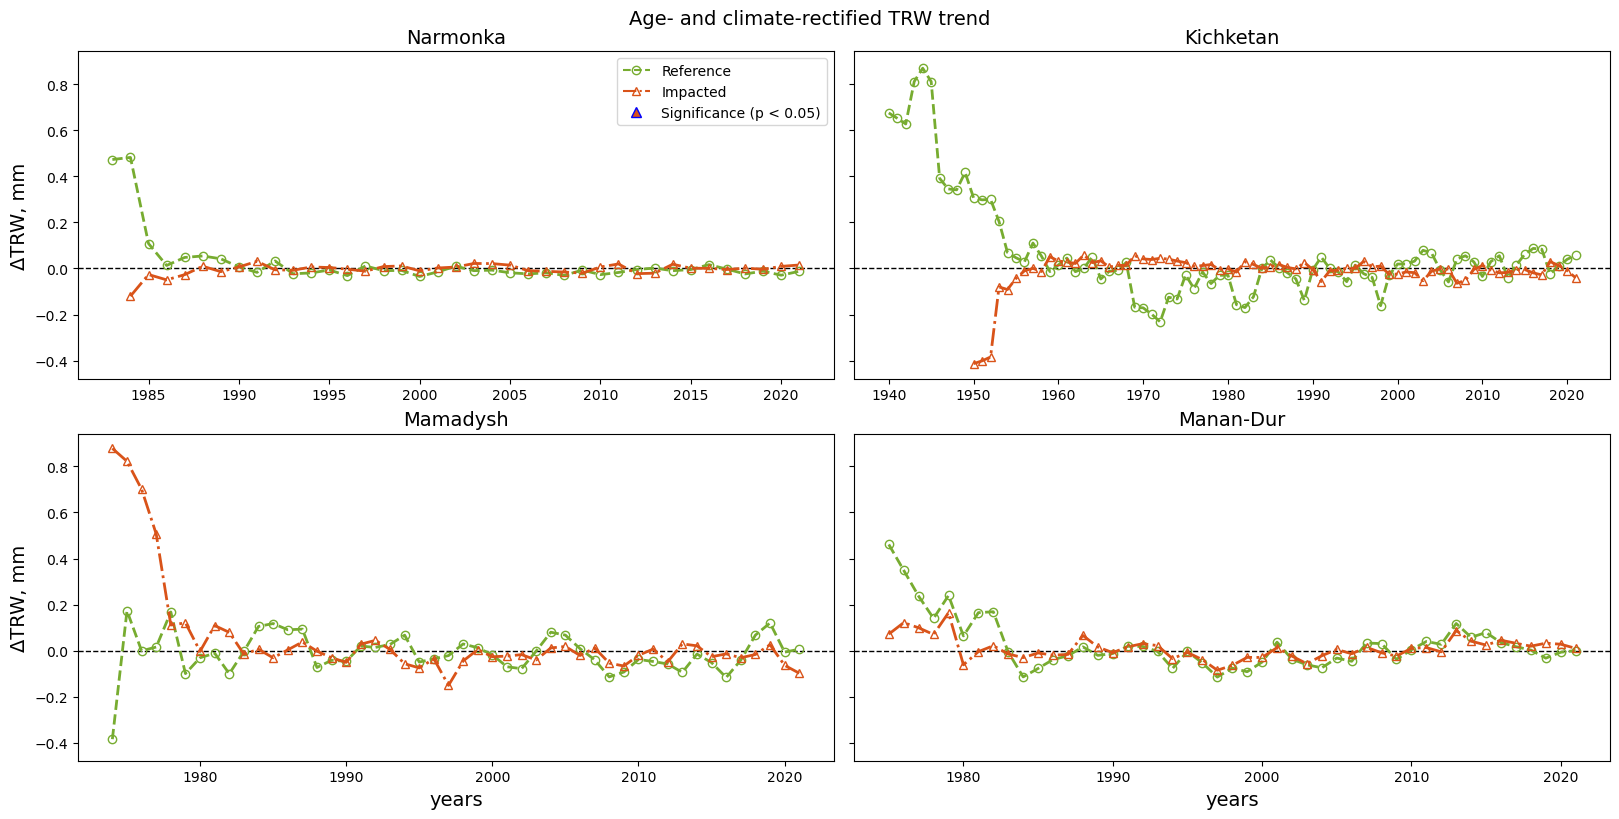

In [21]:
# (18) Climate-rectified TRW trend — cohort comparison
# --- INPUT:  X_reconstr_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_7_BN.pdf, TRW_7_BN.csv
# Rationale:
#   Plot cohort means of the climate-rectified trend and mark per-year differences vs reference.

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)  
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02) 

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)  # Reference
    sel1 = (colony == col_id) & (location == 1)  # Impacted

    y0 = row_nanmean(X_reconstr_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(X_reconstr_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            markersize=6, marker='o', markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            markersize=6, marker='^', markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    # per-year p-values and highlights 
    Pval = pvals_by_year(X_reconstr_trend, sel0, sel1, dates, method=TEST)
    sig  = np.isfinite(Pval) & (Pval < ALPHA) 
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)  

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)    

    # [DIAG] 
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][CLIM-TREND] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Age- and climate-rectified TRW trend', fontsize=14) 

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')
 
fig.savefig(RESULTS / "Figure_7_BN.pdf", format="pdf")  
pd.DataFrame(X_reconstr_trend).to_csv(RESULTS / "TRW_7_BN.csv", index=False, header=False)
plt.show()


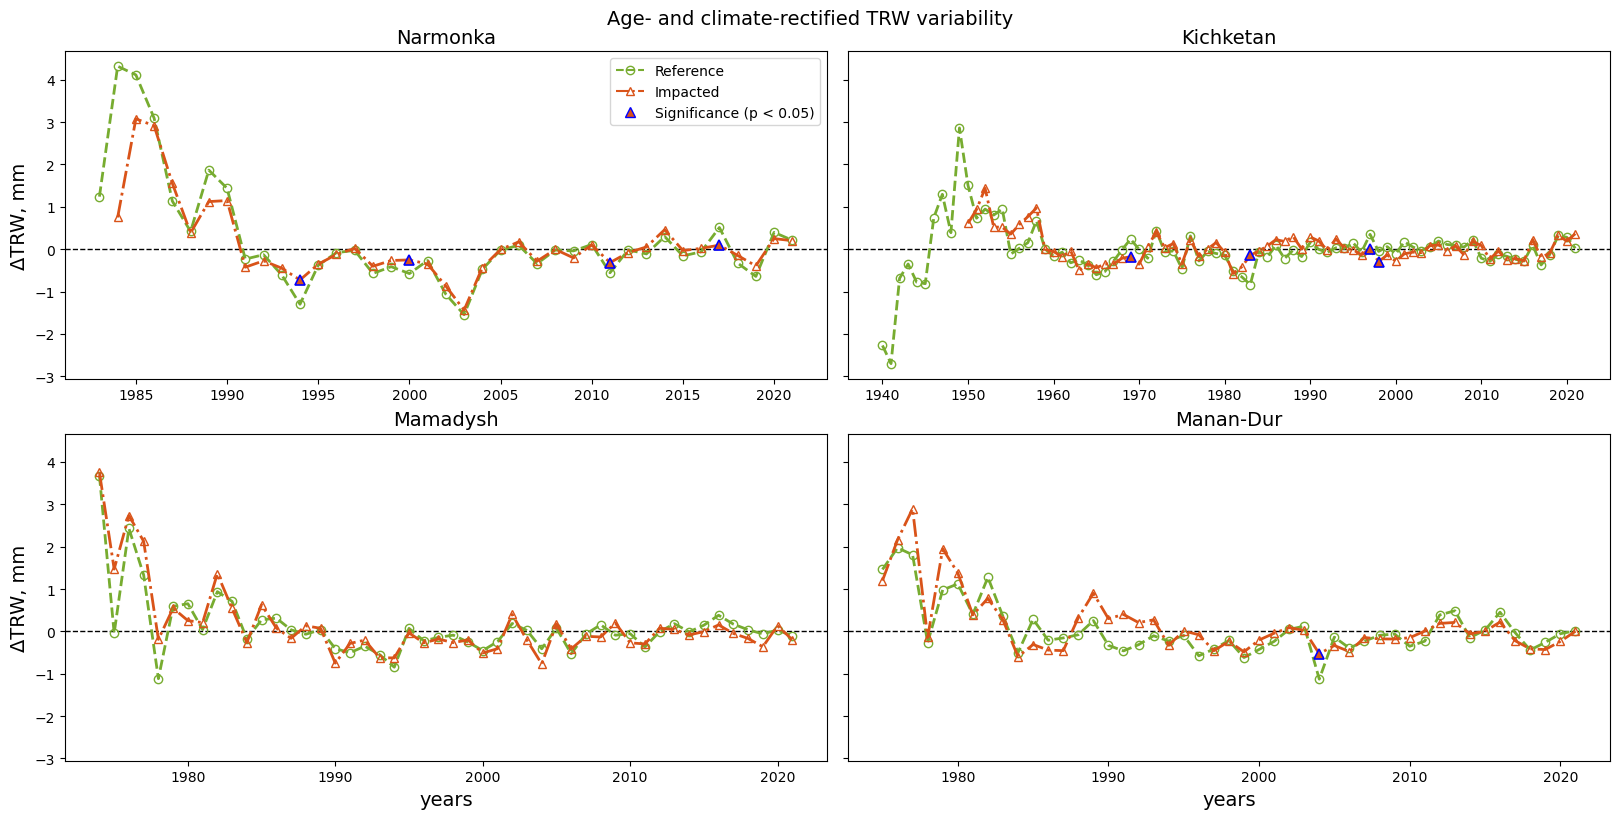

In [22]:
# (19) Climate-rectified TRW variability — cohort comparison
# --- INPUT:  X_reconstr_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_8_BN.pdf, TRW_8_BN.csv
# Rationale:
#   Mirror the trend visualization for the residual (stationary) variability with a zero baseline.

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02) 

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)
    sel1 = (colony == col_id) & (location == 1)

    y0 = row_nanmean(X_reconstr_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(X_reconstr_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])  
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1]) 

    Pval = pvals_by_year(X_reconstr_fluct, sel0, sel1, dates, method=TEST)
    sig  = np.isfinite(Pval) & (Pval < ALPHA) 
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)  

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)  

    # [DIAG]
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][CLIM-VAR] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Age- and climate-rectified TRW variability', fontsize=14) 

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')

fig.savefig(RESULTS / "Figure_8_BN.pdf", format="pdf") 
pd.DataFrame(X_reconstr_fluct).to_csv(RESULTS / "TRW_8_BN.csv", index=False, header=False)
plt.show()


In [23]:
# (20) Extract localized intervention trend (column-wise demeaning)
# --- INPUT:  X_reconstr_trend (T×N)
# --- OUTPUT: Xa_extr_trend (T×N), TRW_9_BN.csv
# Rationale:
#   Demean each tree’s residual trend to isolate within-tree, site-localized deviations.
#   Preserve NaNs and index alignment.

T, N = X_reconstr_trend.shape
mu_trend = np.nanmean(X_reconstr_trend, axis=0)         # (N,)
Xa_extr_trend = X_reconstr_trend - mu_trend[None, :]    # (T×N), NaNs preserved

# [DIAG]
# diag_print("Xa_extr_trend (T x N)", Xa_extr_trend)

# Save
pd.DataFrame(Xa_extr_trend).to_csv(RESULTS / "TRW_9_BN.csv", index=False, header=False)

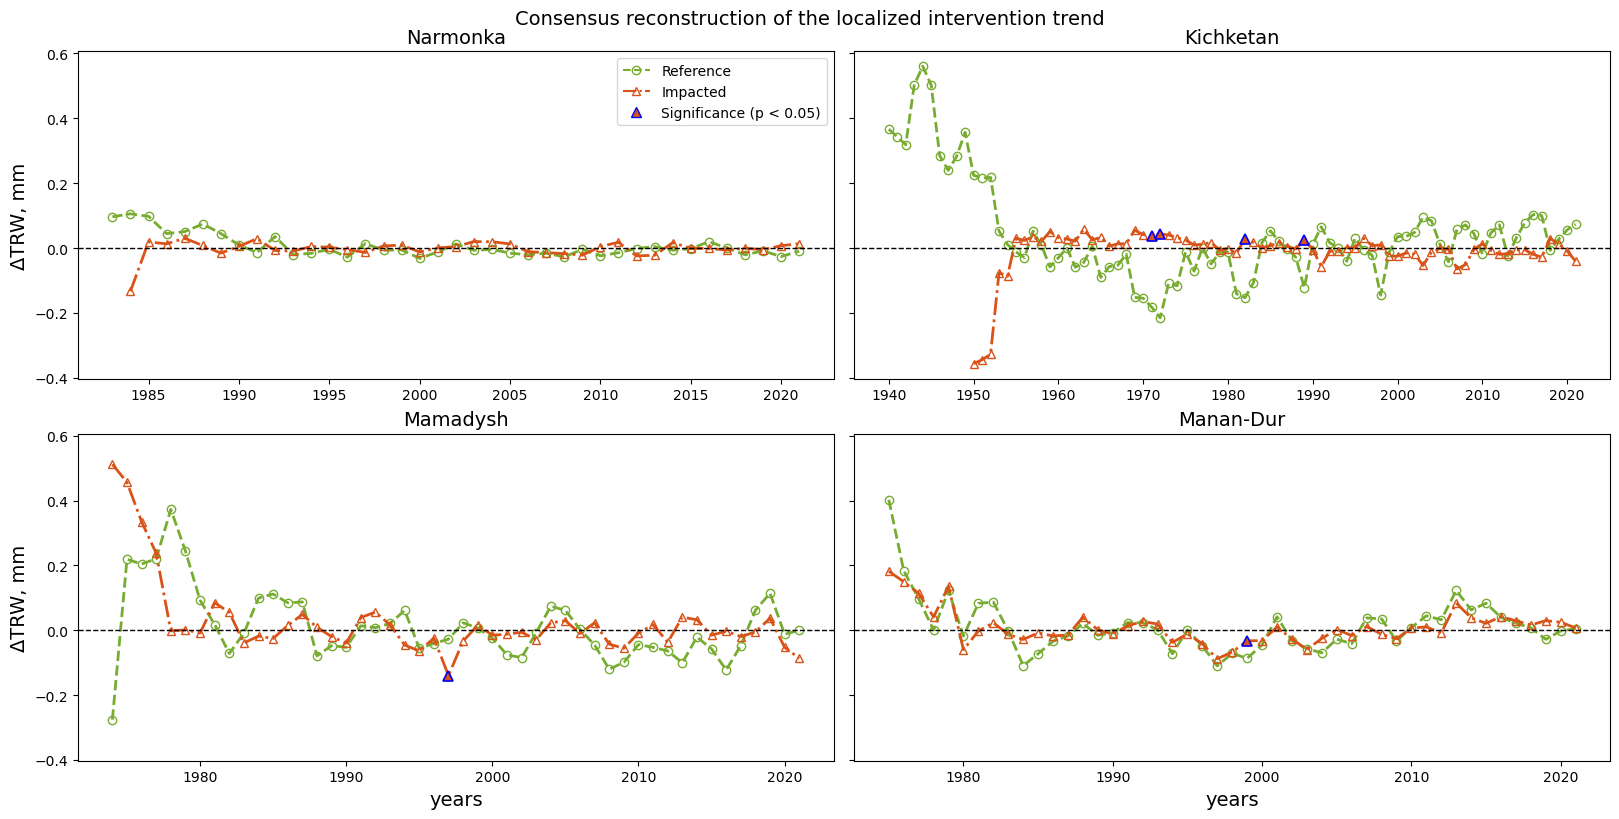

In [24]:
# (21) Localized intervention trend — cohort means with per-year tests
# --- INPUT:  Xa_extr_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_9_BN.pdf
# Rationale:
#   Compare cohort means of localized trend and highlight years different from the reference group.

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True) 
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)  # Reference
    sel1 = (colony == col_id) & (location == 1)  # Impacted

    y0 = row_nanmean(Xa_extr_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(Xa_extr_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    # Per-year p-values and significance highlighting
    Pval = pvals_by_year(Xa_extr_trend, sel0, sel1, dates, method=TEST)
    sig  = np.isfinite(Pval) & (Pval < ALPHA) 
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2) 

    ax.axhline(0.0, linestyle='--', linewidth=1, color='k')

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)  

    # [DIAG]
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][TREND] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Consensus reconstruction of the localized intervention trend', fontsize=14) 

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')

fig.savefig(RESULTS / "Figure_9_BN.pdf", format="pdf")  
plt.show()


In [25]:
# (22) Extract localized intervention fluctuations (column-wise demeaning)
# --- INPUT:  X_reconstr_fluct (T×N)
# --- OUTPUT: Xa_extr_fluct (T×N), TRW_10_BN.csv
# Rationale:
#   Demean each tree’s residual variability to obtain within-tree localized fluctuations.

T, N = X_reconstr_fluct.shape
mu_fluct = np.nanmean(X_reconstr_fluct, axis=0)         # (N,)
Xa_extr_fluct = X_reconstr_fluct - mu_fluct[None, :]    # (T×N)

# [DIAG]
# diag_print("Xa_extr_fluct (T x N)", Xa_extr_fluct)

# Save
pd.DataFrame(Xa_extr_fluct).to_csv(RESULTS / "TRW_10_BN.csv", index=False, header=False)

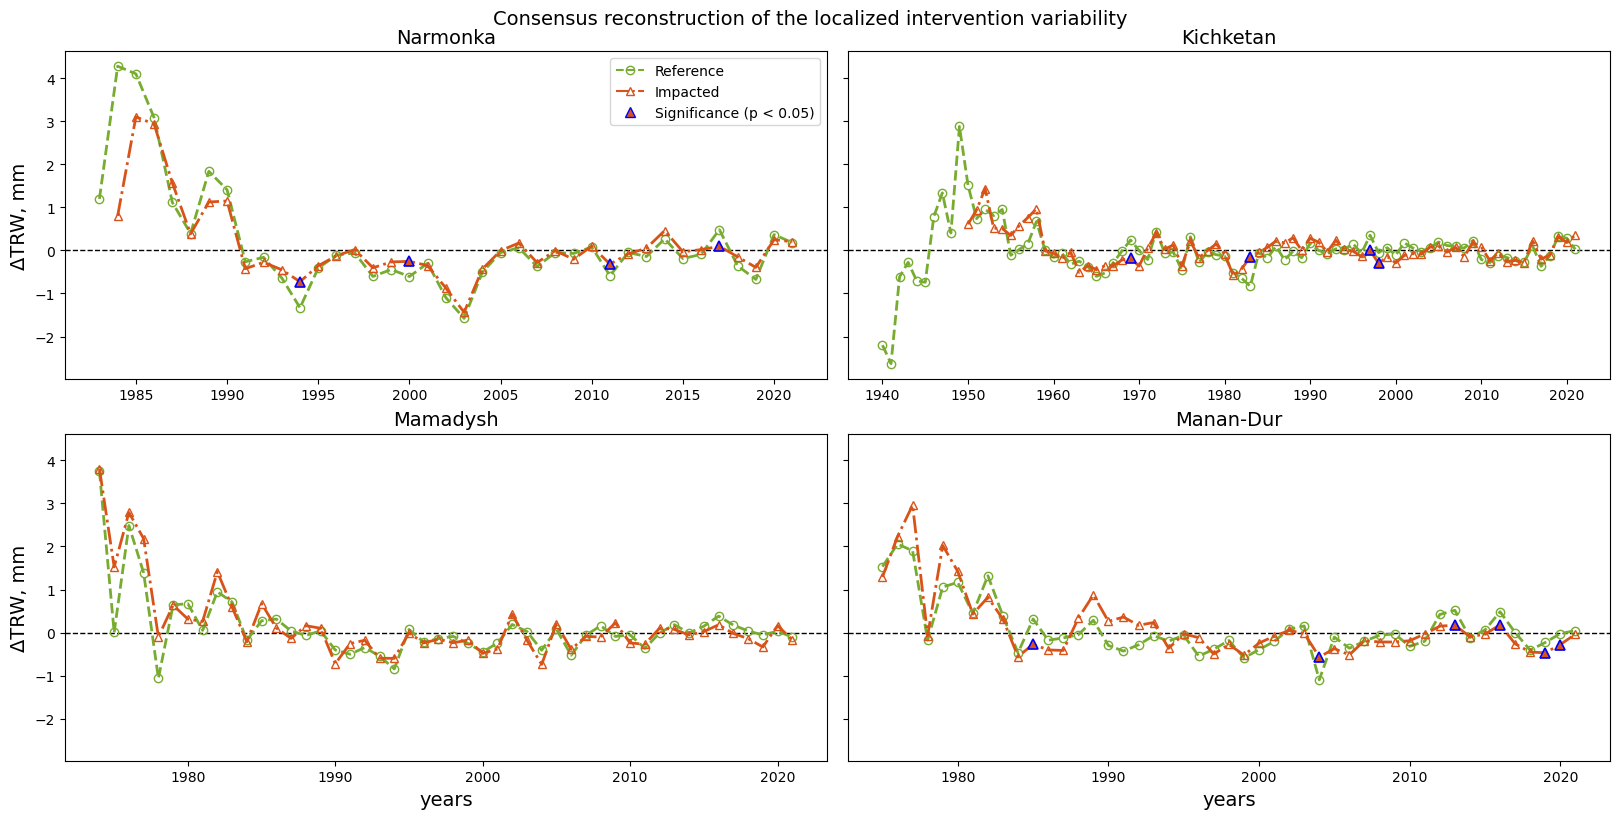

In [26]:
# (23) Localized intervention variability — cohort means with per-year tests
# --- INPUT:  Xa_extr_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_10_BN.pdf
# Rationale:
#   Plot cohort means of localized variability and mark years different from the reference cohort.

col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]
T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True) 
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02) 

for ax, col_id in zip(axes, col_ids):
    sel0 = (colony == col_id) & (location == 0)  # Reference
    sel1 = (colony == col_id) & (location == 1)  # Impacted

    y0 = row_nanmean(Xa_extr_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(Xa_extr_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    # Per-year p-values and significance highlighting
    Pval = pvals_by_year(Xa_extr_fluct, sel0, sel1, dates, method=TEST)
    sig  = np.isfinite(Pval) & (Pval < ALPHA) 
    y1_sig = y1.copy(); y1_sig[~sig] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (list(col_ids).index(col_id) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14) 
    if (list(col_ids).index(col_id) // 2) == 1:
        ax.set_xlabel('years', fontsize=14)  

    # [DIAG]
    # sig_cnt = int(np.nansum(sig))
    # print(f"[DIAG][FLUCT] Colony {col_id}: n0={sel0.sum()}, n1={sel1.sum()}, significant years = {sig_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Consensus reconstruction of the localized intervention variability', fontsize=14) 

axes[0].legend([h_ref, h_imp, sig_handle],
               [loc_names[0], loc_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best') 
fig.savefig(RESULTS / "Figure_10_BN.pdf", format="pdf")  
plt.show()


Narmonka
    C_aver    C_spec    C_unspec  C_sp/C_unsp
    -0.0447     0.6748     0.2691     2.5077

Kichketan
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.4002     0.8595     0.2014     4.2682

Mamadysh
    C_aver    C_spec    C_unspec  C_sp/C_unsp
    -0.0637     0.7126     0.2394     2.9762

Manan-Dur
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.2357     0.7273     0.3354     2.1684



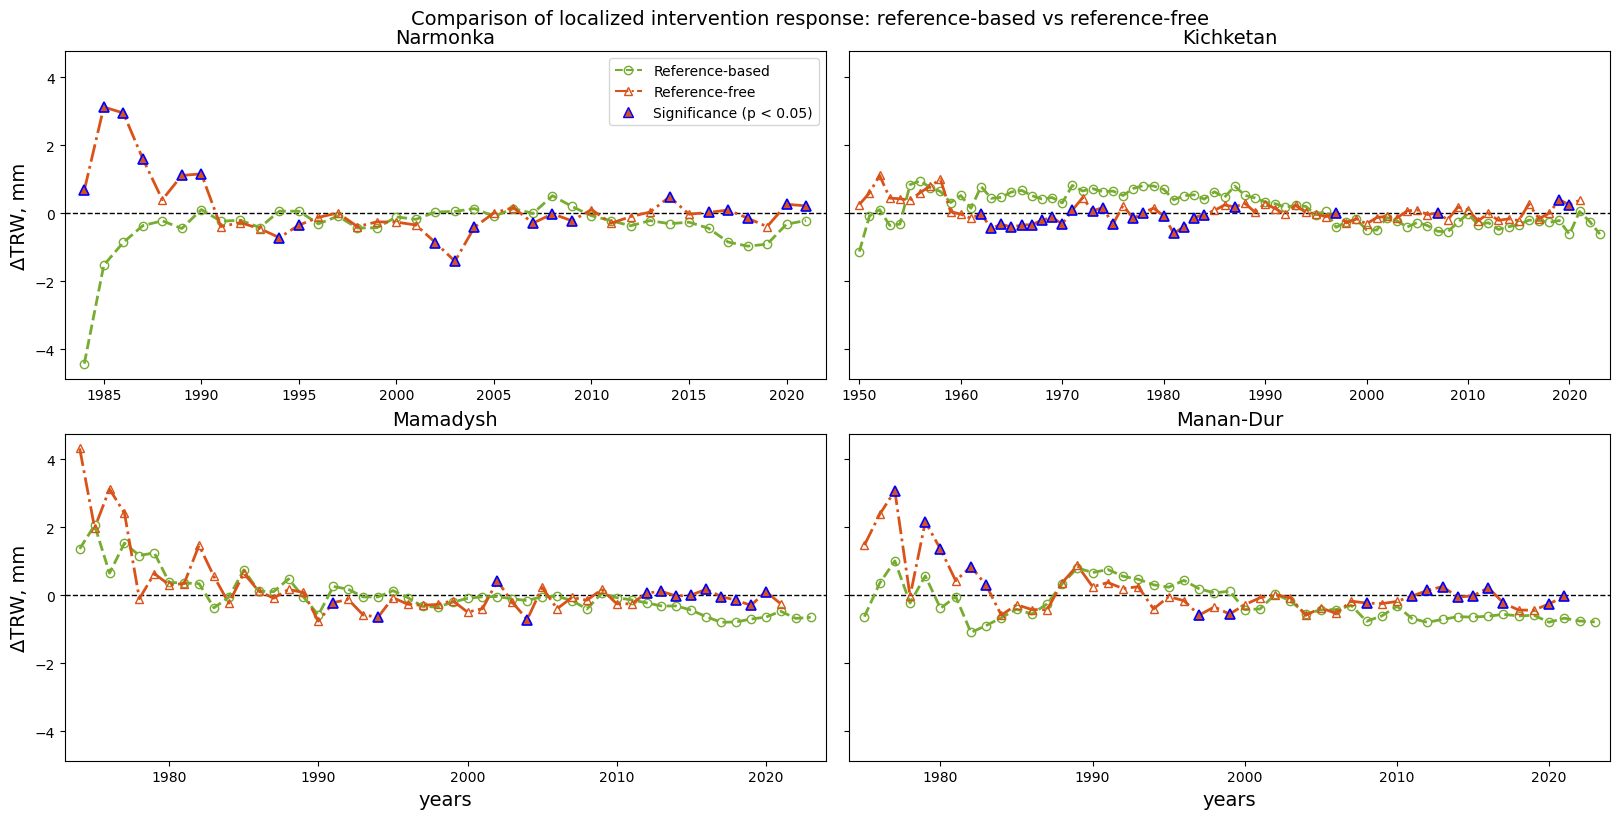

In [27]:
# (24) Comparison against control-based estimates (Reference vs Reference-free)
# --- INPUT:
#   data (T×N), Xa_extr_trend (T×N), Xa_extr_fluct (T×N),
#   dates (T,), colony (N,), location (N,), col_names, loc_names
# --- OUTPUT:
#   TRW_11_BN.csv, TRW_11_BN_data_ctrl.csv, Figure_11_BN.pdf, TRW_11_BN_table.csv
# Rationale:
#   For each colony, compare impacted-cohort series derived in two ways:
#     (i) Reference-based: impacted minus control mean
#     (ii) Reference-free: mean over impacted of (Xa_extr_trend + Xa_extr_fluct)
#   Highlight years where these two approaches differ significantly (p < ALPHA),
#   and report “tail” correlations between per-tree deviations of (i) vs (ii).

T, N = data.shape
col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]

Xa_extr = Xa_extr_trend + Xa_extr_fluct
legend_names = ["Reference-based", "Reference-free"]

# choose a tail start year present in dates (example: 1990)
tail_year = 1990
ix = np.flatnonzero(dates == tail_year)
if ix.size == 0:
    tail_year = int(dates[max(0, len(dates)//2)])  # fallback: mid-series
    ix = np.flatnonzero(dates == tail_year)
tail_start = int(ix[0])
# [DIAG]
# print(f"[DIAG][CTRL] tail_start: idx={tail_start}, year={int(dates[tail_start])}")

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

ctrl_lines, corr_lines = [], []
data_ctrl = np.full_like(data, np.nan)
global_vals = []

for pi, col_id in enumerate(col_ids):
    ax = axes[pi]
    sel_ref = (colony == col_id) & (location == 0)
    sel_imp = (colony == col_id) & (location == 1)

    y_ref = row_nanmean(data[:, sel_ref]) if sel_ref.any() else np.full(T, np.nan)
    y_imp = row_nanmean(data[:, sel_imp]) if sel_imp.any() else np.full(T, np.nan)
    y_refbased = y_imp - y_ref

    ref_free_mat = Xa_extr[:, sel_imp]
    y_reffree    = row_nanmean(ref_free_mat) if sel_imp.any() else np.full(T, np.nan)

    # per-year tests between (i) and (ii)
    Pval = np.full(T, np.nan)
    if sel_ref.any() and sel_imp.any():
        ctrl_mean = row_nanmean(data[:, sel_ref])[:, None]
        naive_vecs = data[:, sel_imp] - ctrl_mean
        recon_vecs = ref_free_mat
        for ti in range(T):
            x = naive_vecs[ti, :]
            y = recon_vecs[ti, :]
            m = np.isfinite(x) & np.isfinite(y)
            if m.sum() >= 1 and np.isfinite(ctrl_mean[ti, 0]):
                Pval[ti] = pval_two_group(x[m], y[m], method=TEST)

    sig = np.isfinite(Pval) & (Pval < ALPHA)
    ctrl_lines.append(
        f"[DIAG][CTRL] Colony {col_id}: n_ref={sel_ref.sum()}, n_imp={sel_imp.sum()}, "
        f"significant years = {int(np.nansum(sig))} (TEST={TEST}, ALPHA={ALPHA})"
    )

    # baselines
    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    ax.plot(dates, y_refbased, linestyle='--', linewidth=2, color=C0,
            markersize=6, marker='o', markerfacecolor='none', markeredgecolor=C0, label=legend_names[0])
    ax.plot(dates, y_reffree,  linestyle='-.', linewidth=2, color=C1,
            markersize=6, marker='^', markerfacecolor='none', markeredgecolor=C1, label=legend_names[1])

    # significance overlay on reference-free
    y_rf_sig = y_reffree.copy(); y_rf_sig[~sig] = np.nan
    ax.plot(dates, y_rf_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

    valid_year = np.isfinite(y_refbased) | np.isfinite(y_reffree)
    if valid_year.any():
        yrs = dates[valid_year]
        ax.set_xlim(int(yrs.min()) - 1, int(yrs.max()) + 1)

        # accumulate Y for shared limits across panels
        x0, x1 = ax.get_xlim()
        idx = (dates >= x0) & (dates <= x1)
        vals = np.r_[y_refbased[idx], y_reffree[idx]]
        vals = vals[np.isfinite(vals)]
        if vals.size: global_vals.append(vals)

    title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    ax.set_title(title, fontsize=14)
    if (pi % 2) == 0:
        ax.set_ylabel("ΔTRW, mm", fontsize=14)
    if (pi // 2) == 1:
        ax.set_xlabel("years", fontsize=14)

    # tail correlations
    if sel_ref.any() and sel_imp.any():
        A = (data[:, sel_imp] - row_nanmean(data[:, sel_ref])[:, None])[tail_start:, :]
        B = ref_free_mat[tail_start:, :]
        if A.size and B.size:
            m = A.shape[1]
            C = np.full((m, m), np.nan)
            for i in range(m):
                ai = A[:, i]
                for j in range(m):
                    bj = B[:, j]
                    mask = np.isfinite(ai) & np.isfinite(bj)
                    if mask.sum() >= 2:
                        C[i, j] = pearsonr(ai[mask], bj[mask]).statistic
            c_aver = corr_1d_pairwise(y_refbased[tail_start:], y_reffree[tail_start:])
            diag_vals = np.diag(C)
            off_vals  = np.abs(C[~np.eye(C.shape[0], dtype=bool)])
            med_diag  = np.nanmedian(diag_vals) if diag_vals.size else np.nan
            med_off   = np.nanmedian(off_vals)  if off_vals.size  else np.nan
            ratio     = (med_diag / med_off) if np.isfinite(med_diag) and np.isfinite(med_off) and med_off != 0 else np.nan
            corr_lines.append(
                f"[DIAG][CTRL][corr] Colony {col_id} (tail_year={int(tail_year)}): "
                f"C_aver={c_aver:.4f}, med(diag)={med_diag:.4f}, med(|off|)={med_off:.4f}, ratio={ratio:.4f}"
            )

    # build centered deviations for audit
    if sel_ref.any():
        ctrl_mean = row_nanmean(data[:, sel_ref])[:, None]
        data_ctrl[:, sel_ref] = data[:, sel_ref] - ctrl_mean
        if sel_imp.any():
            data_ctrl[:, sel_imp] = data[:, sel_imp] - ctrl_mean

# shared Y across panels
if global_vals:
    all_vals = np.concatenate(global_vals)
    ymin, ymax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    pad = 0.05 * max(1.0, ymax - ymin)
    for ax in axes:
        ax.set_ylim(ymin - pad, ymax + pad)

axes[0].legend([h_ref, h_imp, sig_handle],
               [legend_names[0], legend_names[1], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc="best")

plt.suptitle("Comparison of localized intervention response: reference-based vs reference-free", fontsize=14)
fig.savefig(RESULTS / "Figure_11_BN.pdf", format="pdf")

# print table & also save it as CSV 
rows = []
for col_id in col_ids:
    col_title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
    print(f"{col_title}")
    print("    C_aver    C_spec    C_unspec  C_sp/C_unsp")

    line = next((ln for ln in corr_lines if f"Colony {col_id} " in ln), None)
    if line:
        def _extract(tag, ln=line):
            m = re.search(tag + r"\s*=\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", ln)
            return float(m.group(1)) if m else np.nan

        c_aver   = _extract(r"C_aver")
        med_diag = _extract(r"med\(diag\)")
        med_off  = _extract(r"med\(\|off\|\)")
        ratio    = _extract(r"ratio")

        if np.isfinite(c_aver) and np.isfinite(med_diag) and np.isfinite(med_off) and np.isfinite(ratio):
            print(f"    {c_aver:7.4f}    {med_diag:7.4f}    {med_off:7.4f}    {ratio:7.4f}\n")
        else:
            print("    NaN       NaN       NaN       NaN\n")
        rows.append({
            "Colony": col_title,
            "C_aver": c_aver,
            "C_spec": med_diag,
            "C_unspec": med_off,
            "C_sp/C_unsp": ratio
        })
    else:
        print("    NaN       NaN       NaN       NaN\n")
        rows.append({
            "Colony": col_title,
            "C_aver": np.nan,
            "C_spec": np.nan,
            "C_unspec": np.nan,
            "C_sp/C_unsp": np.nan
        })

pd.DataFrame(rows, columns=["Colony","C_aver","C_spec","C_unspec","C_sp/C_unsp"]).to_csv(RESULTS / "TRW_11_BN_table.csv", index=False)

# [DIAG]
# for line in ctrl_lines: print(line)
# for line in corr_lines: print(line)

pd.DataFrame(Xa_extr).to_csv(RESULTS / "TRW_11_BN.csv", index=False, header=False)
pd.DataFrame(data_ctrl).to_csv(RESULTS / "TRW_11_BN_data_ctrl.csv", index=False, header=False)
plt.show()


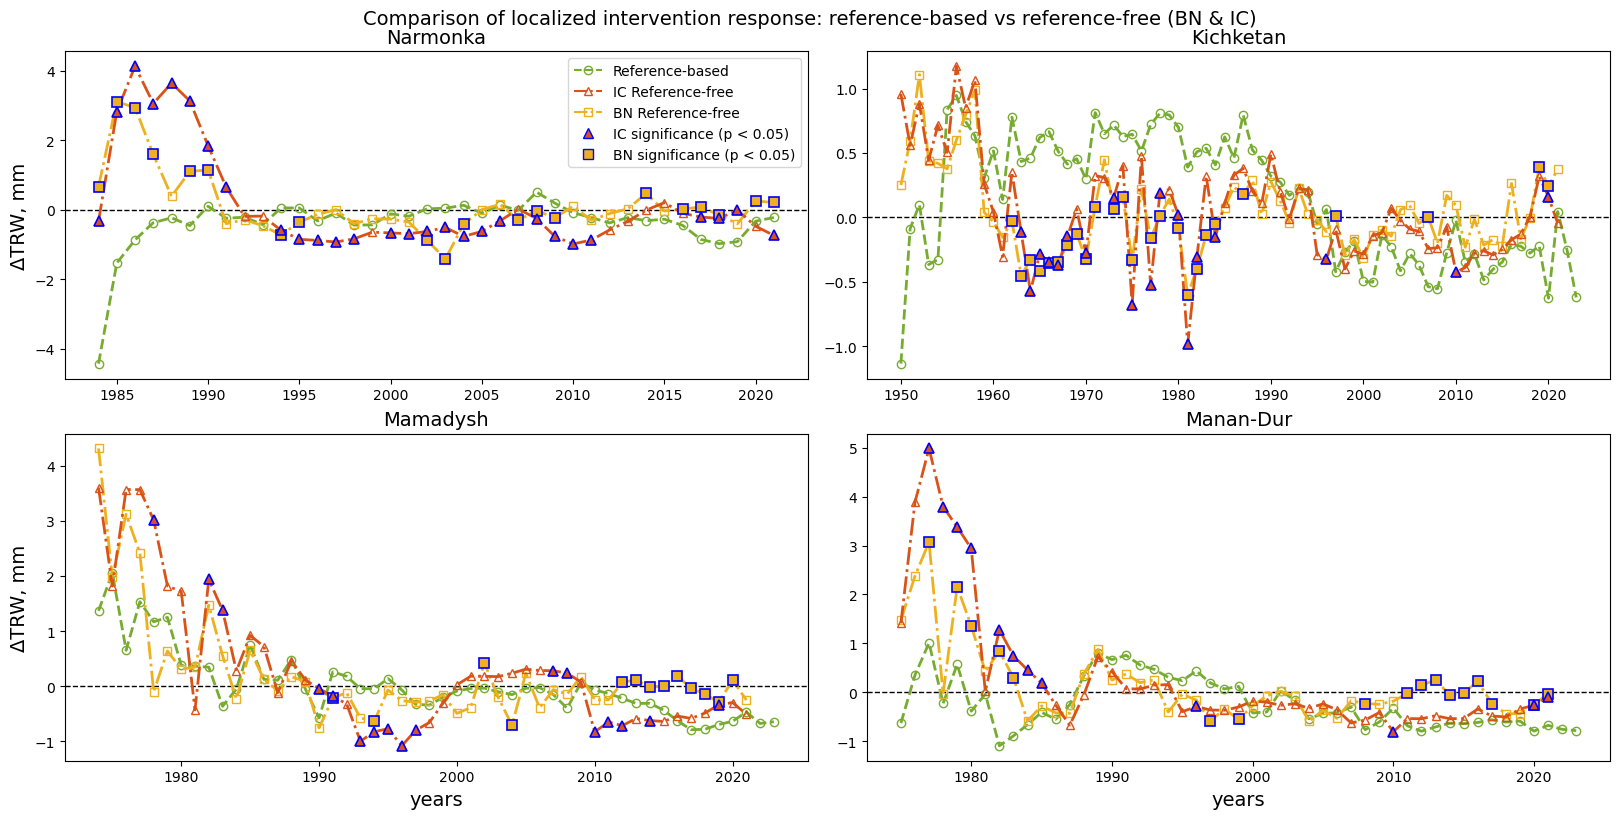

In [31]:
# (25) Replot comparison adding IC curve if TRW_11_IC.csv exists
# --- INPUT: data, dates, colony, location, col_names, loc_names, Xa_extr (BN)
# --- OUTPUT: Figure_11_BN_IC.pdf
C2 = [0.9290, 0.6940, 0.1250]

IC_path = RESULTS / "TRW_11_IC.csv"
if IC_path.exists():
    Xa_extr_IC = pd.read_csv(IC_path, header=None).to_numpy(float)  # (T×N), IC analogue of Xa_extr
    assert Xa_extr_IC.shape == Xa_extr.shape, "[ERR] Shape mismatch for TRW_11_IC.csv"

    col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]
    T = len(dates)

    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False, constrained_layout=True)
    axes = axes.ravel()
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

    legend_names = ["Reference-based", "IC Reference-free", "BN Reference-free"]

    # significance legend handles
    sig_bn_handle = Line2D([], [], ls="None", marker="^", color="b", mfc=C1, mec="b", ms=7)
    sig_ic_handle = Line2D([], [], ls="None", marker="s", color="b", mfc=C2, mec="b", ms=7)

    for pi, col_id in enumerate(col_ids):
        ax = axes[pi]
        sel_ref = (colony == col_id) & (location == 0)
        sel_imp = (colony == col_id) & (location == 1)

        y_ref = row_nanmean(data[:, sel_ref]) if sel_ref.any() else np.full(T, np.nan)
        y_imp = row_nanmean(data[:, sel_imp]) if sel_imp.any() else np.full(T, np.nan)
        y_refbased   = y_imp - y_ref

        y_reffree_BN  = row_nanmean(Xa_extr[:,     sel_imp]) if sel_imp.any() else np.full(T, np.nan)
        y_reffree_IC  = row_nanmean(Xa_extr_IC[:,  sel_imp]) if sel_imp.any() else np.full(T, np.nan)

        # per-year tests (Reference-based vs BN)
        Pval_BN = np.full(T, np.nan)
        if sel_ref.any() and sel_imp.any():
            ctrl_mean = row_nanmean(data[:, sel_ref])[:, None]
            naive_vecs = data[:, sel_imp] - ctrl_mean          # reference-based per-tree
            recon_vecs_BN = Xa_extr[:, sel_imp]                # BN per-tree
            for ti in range(T):
                x = naive_vecs[ti, :]
                y = recon_vecs_BN[ti, :]
                m = np.isfinite(x) & np.isfinite(y)
                if m.sum() >= 1 and np.isfinite(ctrl_mean[ti, 0]):
                    Pval_BN[ti] = pval_two_group(x[m], y[m], method=TEST)

        sig_BN = np.isfinite(Pval_BN) & (Pval_BN < ALPHA)

        # per-year tests (Reference-based vs IC)
        Pval_IC = np.full(T, np.nan)
        if sel_ref.any() and sel_imp.any():
            ctrl_mean = row_nanmean(data[:, sel_ref])[:, None]
            naive_vecs = data[:, sel_imp] - ctrl_mean          # reference-based per-tree
            recon_vecs_IC = Xa_extr_IC[:, sel_imp]             # IC per-tree
            for ti in range(T):
                x = naive_vecs[ti, :]
                y = recon_vecs_IC[ti, :]
                m = np.isfinite(x) & np.isfinite(y)
                if m.sum() >= 1 and np.isfinite(ctrl_mean[ti, 0]):
                    Pval_IC[ti] = pval_two_group(x[m], y[m], method=TEST)

        sig_IC = np.isfinite(Pval_IC) & (Pval_IC < ALPHA)

        # curves
        ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
        ax.plot(dates, y_refbased,   ls='--', lw=2, color=C0, marker='o', ms=6, mfc='none', mec=C0, label=legend_names[0])
        ax.plot(dates, y_reffree_BN, ls='-.', lw=2, color=C2, marker='s', ms=6, mfc='none', mec=C2, label=legend_names[1])
        ax.plot(dates, y_reffree_IC, ls='-.', lw=2, color=C1, marker='^', ms=6, mfc='none', mec=C1, label=legend_names[2])

        # significance overlays (BN triangles, IC squares)
        y_bn_sig = y_reffree_BN.copy(); y_bn_sig[~sig_BN] = np.nan
        ax.plot(dates, y_bn_sig, linestyle='None', marker='s', markersize=7,
                markerfacecolor=C2, markeredgecolor='b', markeredgewidth=1.2)
        y_ic_sig = y_reffree_IC.copy(); y_ic_sig[~sig_IC] = np.nan
        ax.plot(dates, y_ic_sig, linestyle='None', marker='^', markersize=7,
                markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

        title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
        ax.set_title(title, fontsize=14)
        if (pi % 2) == 0:  ax.set_ylabel("ΔTRW, mm", fontsize=14)
        if (pi // 2) == 1: ax.set_xlabel("years",   fontsize=14)

    # custom legend with significance handles
    base_handles = [
        Line2D([], [], ls='--', color=C0, marker='o', mfc='none', mec=C0, ms=6),
        Line2D([], [], ls='-.', color=C1, marker='^', mfc='none', mec=C1, ms=6),
        Line2D([], [], ls='-.', color=C2, marker='s', mfc='none', mec=C2, ms=6),
        sig_bn_handle, sig_ic_handle
    ]
    base_labels = [
        legend_names[0], legend_names[1], legend_names[2],
        f"IC significance (p < {ALPHA:g})", f"BN significance (p < {ALPHA:g})"
    ]
    axes[0].legend(base_handles, base_labels, loc="best")

    plt.suptitle("Comparison of localized intervention response: reference-based vs reference-free (BN & IC)", fontsize=14)
    fig.savefig(RESULTS / "Figure_11_BN_IC.pdf", format="pdf")
    plt.show()


Narmonka
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.4585     0.7681     0.2338     3.2851

Kichketan
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.6602     0.9446     0.2024     4.6668

Mamadysh
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.0677     0.7099     0.2675     2.6538

Manan-Dur
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.2983     0.8796     0.3167     2.7779



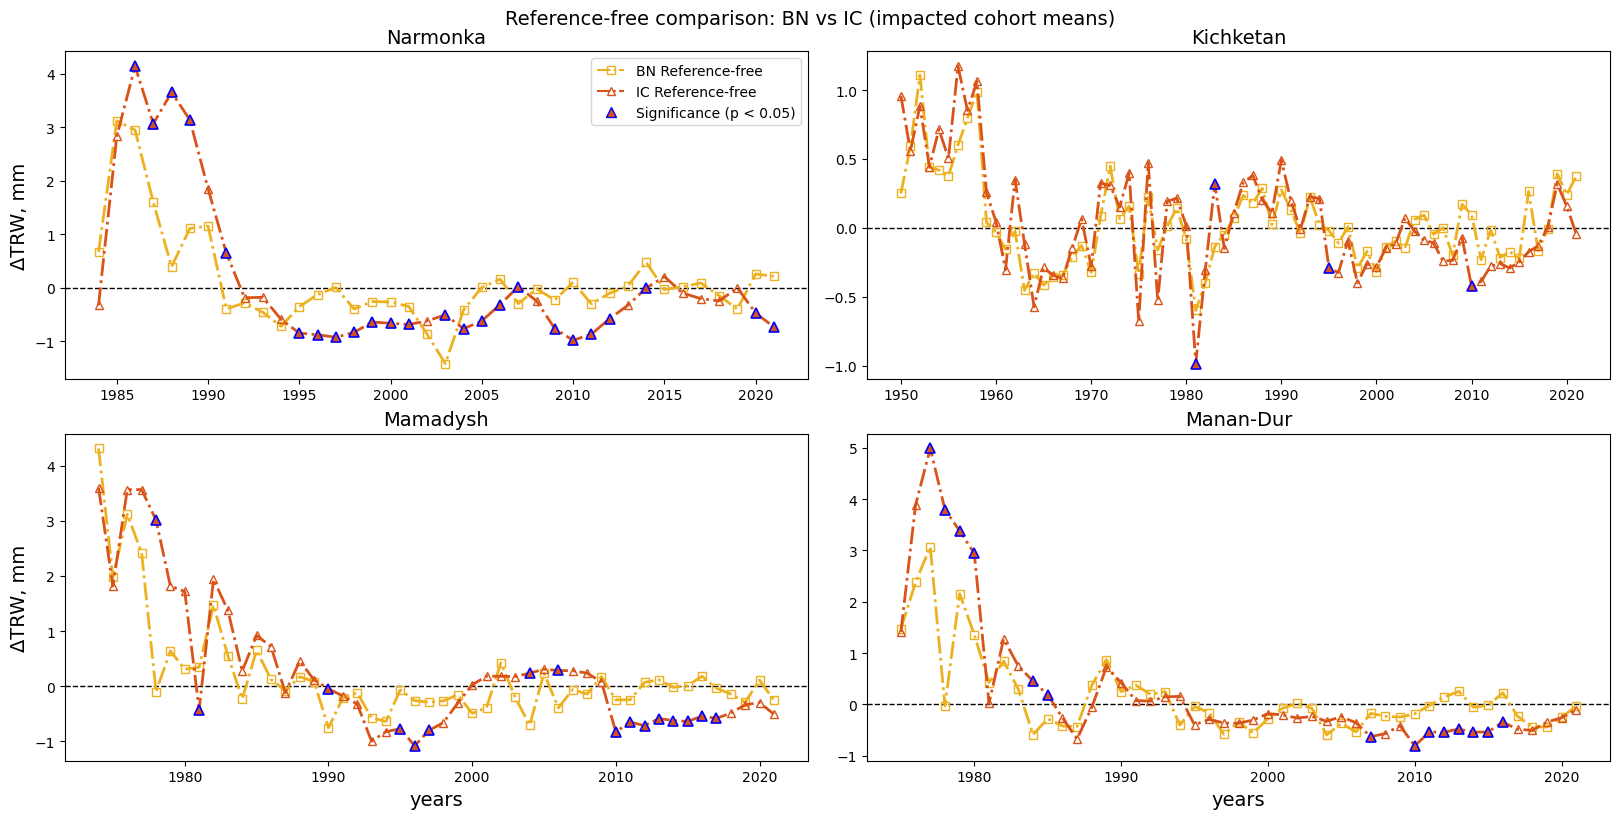

In [32]:
# (26) Comparison between two reference-free methods (BN vs IC)
# --- INPUT:
#   data (T×N), Xa_extr (BN, T×N), dates (T,), colony (N,), location (N,), col_names, loc_names
#   TRW_11_IC.csv (reference-free IC analogue of Xa_extr) must exist
# --- OUTPUT:
#   Figure_11_BN_IC_compare.pdf
# Rationale:
#   For each colony, compare impacted-cohort series derived in two reference-free ways:
#     (i) IC Reference-free: mean over impacted of Xa_extr_IC (age+climate-rectified)
#     (ii) BN Reference-free: mean over impacted of Xa_extr (from NPBN block/output)
#   Highlight years where these two approaches differ signifBNantly (p < ALPHA),
#   and report “tail” correlations between per-tree deviations of (i) vs (ii).

# ensure the IC file exists and shapes match
IC_path = RESULTS / "TRW_11_IC.csv"
if IC_path.exists():
    Xa_extr_IC = pd.read_csv(IC_path, header=None).to_numpy(float)  # (T×N)
    assert Xa_extr_IC.shape == Xa_extr.shape, "[ERR] Shape mismatch for TRW_11_IC.csv"

    # yellow (if not defined earlier)
    try:
        C2
    except NameError:
        C2 = [0.9290, 0.6940, 0.1250]

    T, N = data.shape
    col_ids = np.sort(np.unique(colony[np.isfinite(colony)])).astype(int)[:4]

    legend_names = ["BN Reference-free", "IC Reference-free"]

    # choose a tail start year present in dates (example: 1990)
    tail_year = 1990
    ix = np.flatnonzero(dates == tail_year)
    if ix.size == 0:
        tail_year = int(dates[max(0, len(dates)//2)])  # fallback: mid-series
        ix = np.flatnonzero(dates == tail_year)
    tail_start = int(ix[0])
    # [DIAG]
    # print(f"[DIAG][BNvsIC] tail_start: idx={tail_start}, year={int(dates[tail_start])}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False, constrained_layout=True)
    axes = axes.ravel()
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

    # significance legend handle (IC vs BN, markers on IC)
    sig_ic_handle = Line2D([], [], ls="None", marker="^", color="b", mfc=C1, mec="b", ms=7)

    corr_lines = []
    
    for pi, col_id in enumerate(col_ids):
        ax = axes[pi]
        sel_imp = (colony == col_id) & (location == 1)

        y_bn = row_nanmean(Xa_extr[:,    sel_imp]) if sel_imp.any() else np.full(T, np.nan)
        y_ic = row_nanmean(Xa_extr_IC[:, sel_imp]) if sel_imp.any() else np.full(T, np.nan)

        # per-year tests between BN and IC (per-tree values at each year)
        Pval = np.full(T, np.nan)
        if sel_imp.any():
            recon_bn = Xa_extr[:,    sel_imp]
            recon_ic = Xa_extr_IC[:, sel_imp]
            for ti in range(T):
                x = recon_ic[ti, :]
                y = recon_bn[ti, :]
                m = np.isfinite(x) & np.isfinite(y)
                if m.sum() >= 1:
                    Pval[ti] = pval_two_group(x[m], y[m], method=TEST)

        sig = np.isfinite(Pval) & (Pval < ALPHA)

        # curves
        ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
        ax.plot(dates, y_bn, ls='-.', lw=2, color=C2, marker='s', ms=6, mfc='none', mec=C2, label=legend_names[0])
        ax.plot(dates, y_ic, ls='-.', lw=2, color=C1, marker='^', ms=6, mfc='none', mec=C1, label=legend_names[1])

        # significance overlay on IC (squares)
        y_ic_sig = y_ic.copy(); y_ic_sig[~sig] = np.nan
        ax.plot(dates, y_ic_sig, linestyle='None', marker='^', markersize=7,
                markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

        title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
        ax.set_title(title, fontsize=14)
        if (pi % 2) == 0:
            ax.set_ylabel("ΔTRW, mm", fontsize=14)
        if (pi // 2) == 1:
            ax.set_xlabel("years", fontsize=14)

        # tail correlations (BN vs IC)
        if sel_imp.any():
            A = Xa_extr[tail_start:,    sel_imp]   # BN, per-tree
            B = Xa_extr_IC[tail_start:, sel_imp]   # IC, per-tree
            if A.size and B.size:
                m_imp = A.shape[1]
                C = np.full((m_imp, m_imp), np.nan)
                for i in range(m_imp):
                    ai = A[:, i]
                    for j in range(m_imp):
                        bj = B[:, j]
                        mask = np.isfinite(ai) & np.isfinite(bj)
                        if mask.sum() >= 2:
                            C[i, j] = pearsonr(ai[mask], bj[mask]).statistic

                c_aver = corr_1d_pairwise(y_bn[tail_start:], y_ic[tail_start:])
                diag_vals = np.diag(C)
                off_vals  = np.abs(C[~np.eye(C.shape[0], dtype=bool)])
                med_diag  = np.nanmedian(diag_vals) if diag_vals.size else np.nan
                med_off   = np.nanmedian(off_vals)  if off_vals.size  else np.nan
                ratio     = (med_diag / med_off) if np.isfinite(med_diag) and np.isfinite(med_off) and med_off != 0 else np.nan

                corr_lines.append(
                    f"[DIAG][BNvsIC][corr] Colony {col_id} (tail_year={int(tail_year)}): "
                    f"C_aver={c_aver:.4f}, med(diag)={med_diag:.4f}, med(|off|)={med_off:.4f}, ratio={ratio:.4f}"
                )

    # legend
    axes[0].legend([Line2D([], [], ls='-.', color=C2, marker='s', mfc='none', mec=C2, ms=6),
                    Line2D([], [], ls='-.', color=C1, marker='^', mfc='none', mec=C1, ms=6),
                    sig_ic_handle],
                   [legend_names[0], legend_names[1], f"Significance (p < {ALPHA:g})"],
                   handler_map={tuple: HandlerTuple(ndivide=None)}, loc="best")

    plt.suptitle("Reference-free comparison: BN vs IC (impacted cohort means)", fontsize=14)
    fig.savefig(RESULTS / "Figure_11_BN_IC_compare.pdf", format="pdf")

    # print table & also save it as CSV
    rows = []
    for col_id in col_ids:
        col_title = col_names[col_id-1] if (col_id-1) < len(col_names) else f"Colony {col_id}"
        print(f"{col_title}")
        print("    C_aver    C_spec    C_unspec  C_sp/C_unsp")

        line = next((ln for ln in corr_lines if f"Colony {col_id} " in ln), None)
        if line:
            def _extract(tag, ln=line):
                m = re.search(tag + r"\s*=\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", ln)
                return float(m.group(1)) if m else np.nan

            c_aver   = _extract(r"C_aver")
            med_diag = _extract(r"med\(diag\)")
            med_off  = _extract(r"med\(\|off\|\)")
            ratio    = _extract(r"ratio")

            if np.isfinite(c_aver) and np.isfinite(med_diag) and np.isfinite(med_off) and np.isfinite(ratio):
                print(f"    {c_aver:7.4f}    {med_diag:7.4f}    {med_off:7.4f}    {ratio:7.4f}\n")
            else:
                print("    NaN       NaN       NaN       NaN\n")
            rows.append({
                "Colony": col_title,
                "C_aver": c_aver,
                "C_spec": med_diag,
                "C_unspec": med_off,
                "C_sp/C_unsp": ratio
            })
        else:
            print("    NaN       NaN       NaN       NaN\n")
            rows.append({
                "Colony": col_title,
                "C_aver": np.nan,
                "C_spec": np.nan,
                "C_unspec": np.nan,
                "C_sp/C_unsp": np.nan
            })
    pd.DataFrame(rows, columns=["Colony","C_aver","C_spec","C_unspec","C_sp/C_unsp"]).to_csv(RESULTS / "TRW_11_BN_IC_table.csv", index=False)
    plt.show()
